# NHLPA Salary Predictions
## By Kyle Dufrane

# Business Understanding

### Our stakeholder is the NHLPA (National Hockey League Players Association). Over the long history of the NHL there have been a total of five "lockouts" or player strikes regarding pay. The purpose for this project is to devolop a machine learning model that will predict players salaries, excluding goalies (as this will require another model due to stats), based on prior performance. The NHLPA will be able to use to model, moving forward, to negotiate player contract prices against the NHL. 

In [1]:
# Import needed libraries

from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import pickle

sns.set_style("darkgrid")
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

######################################################################

import requests
import json
from bs4 import BeautifulSoup
import lxml

######################################################################

import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import pearsonr

from itertools import combinations

from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from lazypredict.Supervised import LazyRegressor

from xgboost import XGBRegressor

######################################################################

# All functions are stored in the src folder attached to this repo
import sys
sys.path.insert(0, 'src/')
from modeling import *
from data_cleaning import *

######################################################################

import warnings
warnings.filterwarnings('ignore')

# Data Understanding

### This dataset comes from two sources being: 

* NHL API - player stats by season
* [Spotrac.com Webscraping](www.sportrac.com) - player salaries by season

### Below we will start our data collections. 

### To start, the below cell pulls from the NHL API and extracts all NHL team information and stores the requests objects in a dictionary. We then remove all values that return a 404 error and, store the object in a pickle file, and, finally, convert the raw data into a dataframe. 

#### Note: All pickled objects can be found in the json_files folder

#### Note: This process is identifcal for all NHL API pulls. The NHL API pulls end at cell 24.

In [2]:
# nhl_teams = {}

# for team in range(1,102):
    
#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{team}"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_teams[team] = requests.request("GET", url, headers=headers)


In [3]:
# errors_404 = [59, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83, 84, 85, 86, 99]

# for i in errors_404:
#     nhl_teams.pop(i)

In [4]:
# pickle_out = open("json_files/nhl_teams.pickle","wb")
# pickle.dump(nhl_teams, pickle_out)
# pickle_out.close()

pickle_in = open("json_files/nhl_teams.pickle","rb")
nhl_teams = pickle.load(pickle_in)

all_teams_df = get_teams(nhl_teams)
all_teams_df.head()

,id,name,link,venue_name,venue_link,venue_city,venue_timeZone,abbreviation,teamName,locationName,firstYearOfPlay,division_id,division_name,division_link,conference_id,conference_name,conference_link,franchise_franchiseId,franchise_teamName,franchise_link,shortName,officialSiteUrl,franchiseId,active,venue_id,division_nameShort,division_abbreviation
1,1,New Jersey Devils,/api/v1/teams/1,Prudential Center,/api/v1/venues/null,Newark,America/New_York,NJD,Devils,New Jersey,1982,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,23,Devils,/api/v1/franchises/23,New Jersey,http://www.newjerseydevils.com/,23,True,NaN,NaN,NaN
2,2,New York Islanders,/api/v1/teams/2,Nassau Veterans Memorial Coliseum,/api/v1/venues/null,Uniondale,America/New_York,NYI,Islanders,New York,1972,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,22,Islanders,/api/v1/franchises/22,NY Islanders,http://www.newyorkislanders.com/,22,True,NaN,NaN,NaN
3,3,New York Rangers,/api/v1/teams/3,Madison Square Garden,/api/v1/venues/5054,New York,America/New_York,NYR,Rangers,New York,1926,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,10,Rangers,/api/v1/franchises/10,NY Rangers,http://www.newyorkrangers.com/,10,True,5054,NaN,NaN
4,4,Philadelphia Flyers,/api/v1/teams/4,Wells Fargo Center,/api/v1/venues/5096,Philadelphia,America/New_York,PHI,Flyers,Philadelphia,1967,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,16,Flyers,/api/v1/franchises/16,Philadelphia,http://www.philadelphiaflyers.com/,16,True,5096,NaN,NaN
5,5,Pittsburgh Penguins,/api/v1/teams/5,PPG Paints Arena,/api/v1/venues/5034,Pittsburgh,America/New_York,PIT,Penguins,Pittsburgh,1967,25,MassMutual East,/api/v1/divisions/25,6,Eastern,/api/v1/conferences/6,17,Penguins,/api/v1/franchises/17,Pittsburgh,http://pittsburghpenguins.com/,17,True,5034,NaN,NaN


#### The above dataframe contains information regarding all of the stadims in the NHL. The columns descriptions are:

* id - team ID
* name - full team name
* link - suffix of URL to access specific team's API
* venue_name - stadium name
* venue_link - suffix of URL to access specific venue's API
* venue_city - city of which the venue resides
* venue_timeZone - timezone of the venue
* abbreviation - team name abbreviation
* team_Name - shortened team name (I.E. New Jersey Devils = Devils)
* locationName - State or Province of team
* firstYearOfPlay - first year the team entered the NHL
* division_id - NHL ID number for teams division
* divion_name - name of teams NHL division
* division_link - suffix of URL to access specific division's API
* conference_id - NHL ID number for teams conference
* conference_name - name of teams conference
* conference_link - suffix of URL to access specific conference API
* franchise_franchiseId - NHL ID number for franchise
* franchise_teamName - shortened team name I.E. New Jersey Devils = Devils)
* officialSiteUrl - NHL teams website URL
* franchiseId - NHL ID number for franchise
* active - True/False on whether a team is still playing (I.E. Hartford Whalers would show false)
* venue_id - NHL ID for venues
* division_nameShort - NaN
* division_abbreviation - NaN

#### The above dataframe does not give us any player specific information but since the NHL's API is undocumented we are shooting in the dark as far as what information we will get from our requests. This information doesn't seem to helpful at the moment but it may be useful in the future.

#### Below we attempt to pull stadium and franchise information from the links associated in the above dataframe but are unable to get any return information.

In [5]:
# nhl_team_stadiums = {}

# for link in all_teams_df['venue_link']:

#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{link}/roster"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_team_stadiums[link] = requests.request("GET", url, headers=headers)

print('Response [404]')

Response [404]


In [6]:
# nhl_team_franchise = {}

# for link in all_teams_df['franchise_link']:

#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{link}/roster"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_team_franchise[link] = requests.request("GET", url, headers=headers)

print('Response [404]')

Response [404]


#### Next we move to extract team roster information from the NHL API. Again, we remove the 404 errors, store our JSON files in a dictionary, pickle the object, run our dictionary through our function, and return a pandas dataframe. 

In [7]:
# nhl_team_roster = {}

# for number in range(1,55):

#     url = f"https://statsapi.web.nhl.com/api/v1/teams/{number}/roster"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     nhl_team_roster[number] = requests.request("GET", url, headers=headers)

In [8]:
# roster_error_404 = [11, 27, 31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51]
# for error in roster_error_404:
#     nhl_team_roster.pop(error)

In [9]:
# pickle_out = open("json_files/nhl_rosters.pickle","wb")
# pickle.dump(nhl_team_roster, pickle_out)
# pickle_out.close()

In [10]:
pickle_in = open("json_files/nhl_rosters.pickle","rb")
nhl_rosters = pickle.load(pickle_in)

In [11]:
rosters = build_roster(nhl_rosters)
rosters = rosters.astype('object')
rosters.head()

,id,fullName,link,jerseyNumber,code,name,type,abbreviation,Team_Number
0,8477972,Josh Jacobs,/api/v1/people/8477972,40,D,Defenseman,Defenseman,D,1
1,8478421,A.J. Greer,/api/v1/people/8478421,42,L,Left Wing,Forward,LW,1
2,8474056,P.K. Subban,/api/v1/people/8474056,76,D,Defenseman,Defenseman,D,1
3,8475809,Scott Wedgewood,/api/v1/people/8475809,41,G,Goalie,Goalie,G,1
4,8476807,Matt Tennyson,/api/v1/people/8476807,7,D,Defenseman,Defenseman,D,1


#### This dataframe looks more promising. We get a small amount of player information but we can pull more stats through the 'link' column. Below are descriptions of each column in the dataframe:

* id - NHL player id
* fullName - full name of NHL player
* link - suffix of URL to access specific players API
* jerseyNumber - team number of player
* code - abbreviation of position (I.E. D = Defenseman)
* name - full position name
* type - position type (Forward, Defensement, Goalie)
* abbreviation - full abbreviation of the name column (I.E. Left Wing = LW)
* Team_Number - NHL team number - **Note: this may tie to our teams dataframe on the id column**

#### Next we will pull player specific stats using the link column from the above dataframe & join the new dataframe with the rosters dataframe using the 'id' column

In [12]:
# player_stats = {}
# for link in rosters['link']:

#     url = f"https://statsapi.web.nhl.com/{link}"

#     headers = {
#         'x-rapidapi-key': "c10092ada9mshd8d43cac6b3023cp1b369ajsn4c45f8f530d0",
#         'x-rapidapi-host': "api-hockey.p.rapidapi.com"
#     }

#     player_stats[link] = requests.request("GET", url, headers=headers)

In [13]:
# pickle_out = open("json_files/nhl_player_stats.pickle","wb")
# pickle.dump(player_stats, pickle_out)
# pickle_out.close()

In [14]:
pickle_in = open("json_files/nhl_player_stats.pickle","rb")
nhl_player_stats = pickle.load(pickle_in)

In [15]:
player_stats = player_statistics(rosters, nhl_player_stats)
rosters = player_stats.drop_duplicates()
rosters = rosters.astype('object')
rosters.head()

,id,fullName,link,jerseyNumber,code,name,type,abbreviation,Team_Number,index,id,fullName,link,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,current_team_id,current_team_name,current_team_link,primary_position_code,primary_position_name,primary_position_type,primary_position_abbreviation
0,8477972,Josh Jacobs,/api/v1/people/8477972,40,D,Defenseman,Defenseman,D,1,/api/v1/people/8477972,8477972,Josh Jacobs,/api/v1/people/8477972,Josh,Jacobs,40,1996-02-15,25,Shelby Township,MI,USA,USA,"6' 2""",200,True,False,False,True,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
1,8478421,A.J. Greer,/api/v1/people/8478421,42,L,Left Wing,Forward,LW,1,/api/v1/people/8478421,8478421,A.J. Greer,/api/v1/people/8478421,A.J.,Greer,42,1996-12-14,24,Joliette,QC,CAN,CAN,"6' 3""",210,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,L,Left Wing,Forward,LW
2,8474056,P.K. Subban,/api/v1/people/8474056,76,D,Defenseman,Defenseman,D,1,/api/v1/people/8474056,8474056,P.K. Subban,/api/v1/people/8474056,P.K.,Subban,76,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
3,8475809,Scott Wedgewood,/api/v1/people/8475809,41,G,Goalie,Goalie,G,1,/api/v1/people/8475809,8475809,Scott Wedgewood,/api/v1/people/8475809,Scott,Wedgewood,41,1992-08-14,28,Brampton,ON,CAN,CAN,"6' 2""",207,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,G,Goalie,Goalie,G
4,8476807,Matt Tennyson,/api/v1/people/8476807,7,D,Defenseman,Defenseman,D,1,/api/v1/people/8476807,8476807,Matt Tennyson,/api/v1/people/8476807,Matt,Tennyson,7,1990-04-23,31,Minneapolis,MN,USA,USA,"6' 2""",205,True,False,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D


#### Joining the two dataframes has created redundant columns and a messy dataframe. Below we will clean up our dataframe.

#### We will start by dropping columns that we will use to merge on later on and other redundant columns that will have a negative effect on building our dataframe.

In [16]:
clean_up = rosters.iloc[:, 10:]
clean_up.drop(['fullName', 'link', 'id'], axis=1, inplace=True)
clean_up.head()

,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,current_team_id,current_team_name,current_team_link,primary_position_code,primary_position_name,primary_position_type,primary_position_abbreviation
0,Josh,Jacobs,40,1996-02-15,25,Shelby Township,MI,USA,USA,"6' 2""",200,True,False,False,True,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
1,A.J.,Greer,42,1996-12-14,24,Joliette,QC,CAN,CAN,"6' 3""",210,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,L,Left Wing,Forward,LW
2,P.K.,Subban,76,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
3,Scott,Wedgewood,41,1992-08-14,28,Brampton,ON,CAN,CAN,"6' 2""",207,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,G,Goalie,Goalie,G
4,Matt,Tennyson,7,1990-04-23,31,Minneapolis,MN,USA,USA,"6' 2""",205,True,False,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D


#### Next we will join our dataframes

In [17]:
rosters = pd.concat([rosters.iloc[:,:9], clean_up], axis=1)
rosters.head()

,id,fullName,link,jerseyNumber,code,name,type,abbreviation,Team_Number,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,current_team_id,current_team_name,current_team_link,primary_position_code,primary_position_name,primary_position_type,primary_position_abbreviation
0,8477972,Josh Jacobs,/api/v1/people/8477972,40,D,Defenseman,Defenseman,D,1,Josh,Jacobs,40,1996-02-15,25,Shelby Township,MI,USA,USA,"6' 2""",200,True,False,False,True,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
1,8478421,A.J. Greer,/api/v1/people/8478421,42,L,Left Wing,Forward,LW,1,A.J.,Greer,42,1996-12-14,24,Joliette,QC,CAN,CAN,"6' 3""",210,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,L,Left Wing,Forward,LW
2,8474056,P.K. Subban,/api/v1/people/8474056,76,D,Defenseman,Defenseman,D,1,P.K.,Subban,76,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D
3,8475809,Scott Wedgewood,/api/v1/people/8475809,41,G,Goalie,Goalie,G,1,Scott,Wedgewood,41,1992-08-14,28,Brampton,ON,CAN,CAN,"6' 2""",207,True,False,False,False,L,Y,1,New Jersey Devils,/api/v1/teams/1,G,Goalie,Goalie,G
4,8476807,Matt Tennyson,/api/v1/people/8476807,7,D,Defenseman,Defenseman,D,1,Matt,Tennyson,7,1990-04-23,31,Minneapolis,MN,USA,USA,"6' 2""",205,True,False,False,False,R,Y,1,New Jersey Devils,/api/v1/teams/1,D,Defenseman,Defenseman,D


#### Finally we will drop redundant columns that will be unneeded in our model building process.

In [18]:
rosters = rosters.drop(['firstName',
                         'lastName',
                         'primaryNumber',
                         'current_team_id',
                         'current_team_name',
                         'current_team_link',
                         'primary_position_code',
                         'primary_position_name',
                         'primary_position_type',
                         'primary_position_abbreviation'], axis=1)

In [19]:
rosters.head()

,id,fullName,link,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus
0,8477972,Josh Jacobs,/api/v1/people/8477972,40,D,Defenseman,Defenseman,D,1,1996-02-15,25,Shelby Township,MI,USA,USA,"6' 2""",200,True,False,False,True,R,Y
1,8478421,A.J. Greer,/api/v1/people/8478421,42,L,Left Wing,Forward,LW,1,1996-12-14,24,Joliette,QC,CAN,CAN,"6' 3""",210,True,False,False,False,L,Y
2,8474056,P.K. Subban,/api/v1/people/8474056,76,D,Defenseman,Defenseman,D,1,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y
3,8475809,Scott Wedgewood,/api/v1/people/8475809,41,G,Goalie,Goalie,G,1,1992-08-14,28,Brampton,ON,CAN,CAN,"6' 2""",207,True,False,False,False,L,Y
4,8476807,Matt Tennyson,/api/v1/people/8476807,7,D,Defenseman,Defenseman,D,1,1990-04-23,31,Minneapolis,MN,USA,USA,"6' 2""",205,True,False,False,False,R,Y


#### Below are the column descriptions for our newly created dataframe: 
**Same as from the roster API pull above**
* id - NHL player id
* fullName - full name of NHL player
* link - suffix of URL to access specific players API
* jerseyNumber - team number of player
* code - abbreviation of position (I.E. D = Defenseman)
* name - full position name
* type - position type (Forward, Defensement, Goalie)
* abbreviation - full abbreviation of the name column (I.E. Left Wing = LW)
* Team_Number - NHL team number - **Note: this may tie to our teams dataframe on the id column**

**New Columns**
* birthDate - year/month/day a player was born
* currentAge - age of player
* birthCity - city a player was born
* birthStateProvince - city/province a player was born
* birthCountry - country a player was born
* nationality - nationality of player
* height - height of player
* weight - weight of player
* active - if the player is active or not (True/False)
* alternateCaptain - if the player is an alternative captain (True/False)
* captain - if the player is a captain (True/False)
* rookie - if the player is a rookie or not (True/False)
* shootsCatches - handedness of the player 
* rosterStatus - if the player is on the roster or injury reserve


#### For our final use case with the NHL API we will pull player stats by season going back to 2013-2014 which is as far back as the API will allow. Theres no specific reason for going back this far. At this point, the more data the better.

#### We start by running our rosters through a function which pulls by year than pickle the objects to avoid multiple API pulls.

In [20]:
# player_stats_20202021 = player_stats_by_year(rosters, '20202021' )
# player_stats_20192020 = player_stats_by_year(rosters, '20192020' )
# player_stats_20182019 = player_stats_by_year(rosters, '20182019' )
# player_stats_20172018 = player_stats_by_year(rosters, '20172018' )
# player_stats_20162017 = player_stats_by_year(rosters, '20162017' )
# player_stats_20152016 = player_stats_by_year(rosters, '20152016' )
# player_stats_20142015 = player_stats_by_year(rosters, '20142015' )
# player_stats_20132014 = player_stats_by_year(rosters, '20132014' )

In [21]:
# pickle_out = open("json_files/nhl_player_stats20132014.pickle","wb")
# pickle.dump(player_stats_20132014, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20142015.pickle","wb")
# pickle.dump(player_stats_20142015, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20152016.pickle","wb")
# pickle.dump(player_stats_20152016, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20162017.pickle","wb")
# pickle.dump(player_stats_20162017, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20172018.pickle","wb")
# pickle.dump(player_stats_20172018, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20182019.pickle","wb")
# pickle.dump(player_stats_20182019, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20192020.pickle","wb")
# pickle.dump(player_stats_20192020, pickle_out)
# pickle_out.close()

# pickle_out = open("json_files/nhl_player_stats20202021.pickle","wb")
# pickle.dump(player_stats_20202021, pickle_out)
# pickle_out.close()

In [22]:
pickle_in = open("json_files/nhl_player_stats20132014.pickle","rb")
player_stats_20132014 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20142015.pickle","rb")
player_stats_20142015 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20152016.pickle","rb")
player_stats_20152016 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20162017.pickle","rb")
player_stats_20162017 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20172018.pickle","rb")
player_stats_20172018 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20182019.pickle","rb")
player_stats_20182019 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20192020.pickle","rb")
player_stats_20192020 = pickle.load(pickle_in)

pickle_in = open("json_files/nhl_player_stats20202021.pickle","rb")
player_stats_20202021 = pickle.load(pickle_in)

#### Next we will convert our stored JSON files to dataframes

#### Note: Since we're using previous season stats to predict the next season salary we will not be import the players stats from the 2020-2021 season.

In [23]:
# play_stats_20202021 = extract_player_stats(rosters, player_stats_20202021)
play_stats_20192020 = extract_player_stats(rosters, player_stats_20192020)
play_stats_20182019 = extract_player_stats(rosters, player_stats_20182019)
play_stats_20172018 = extract_player_stats(rosters, player_stats_20172018)
play_stats_20162017 = extract_player_stats(rosters, player_stats_20162017)
play_stats_20152016 = extract_player_stats(rosters, player_stats_20152016)
play_stats_20142015 = extract_player_stats(rosters, player_stats_20142015)
play_stats_20132014 = extract_player_stats(rosters, player_stats_20132014)

#### Next we add a suffix to our columns in each dataframe so that we can easily identify them after we join our dataframes.

In [24]:
# play_stats_20202021 = play_stats_20202021.add_suffix('21')
play_stats_20192020 = play_stats_20192020.add_suffix('20')
play_stats_20182019 = play_stats_20182019.add_suffix('19')
play_stats_20172018 = play_stats_20172018.add_suffix('18')
play_stats_20162017 = play_stats_20162017.add_suffix('17')
play_stats_20152016 = play_stats_20152016.add_suffix('16')
play_stats_20142015 = play_stats_20142015.add_suffix('15')
play_stats_20132014 = play_stats_20132014.add_suffix('14')

#### Now we will rename the index column to link so that we have an identical column to join on.

In [25]:
play_stats_20192020 = play_stats_20192020.rename(columns={'index20': 'link'})
play_stats_20182019 = play_stats_20182019.rename(columns={'index19': 'link'})
play_stats_20172018 = play_stats_20172018.rename(columns={'index18': 'link'})
play_stats_20162017 = play_stats_20162017.rename(columns={'index17': 'link'})
play_stats_20152016 = play_stats_20152016.rename(columns={'index16': 'link'})
play_stats_20142015 = play_stats_20142015.rename(columns={'index15': 'link'})
play_stats_20132014 = play_stats_20132014.rename(columns={'index14': 'link'})

#### Finally we merge all of our dataframes into one.

In [26]:
rosters = rosters.set_index('link').join(play_stats_20192020.set_index('link'), on='link')
rosters = rosters.join(play_stats_20182019.set_index('link'), on='link')
rosters = rosters.join(play_stats_20172018.set_index('link'), on='link')
rosters = rosters.join(play_stats_20162017.set_index('link'), on='link')
rosters = rosters.join(play_stats_20152016.set_index('link'), on='link')
rosters = rosters.join(play_stats_20142015.set_index('link'), on='link')
rosters = rosters.join(play_stats_20132014.set_index('link'), on='link')

In [27]:
rosters.head()

,id,fullName,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,season20,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ot20,shutouts20,ties20,wins20,losses20,saves20,powerPlaySaves20,shortHandedSaves20,evenSaves20,shortHandedShots20,evenShots20,powerPlayShots20,savePercentage20,goalAgainstAverage20,gamesStarted20,shotsAgainst20,goalsAgainst20,powerPlaySavePercentage20,shortHandedSavePercentage20,evenStrengthSavePercentage20,season19,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ot19,shutouts19,ties19,wins19,losses19,saves19,powerPlaySaves19,shortHandedSaves19,evenSaves19,shortHandedShots19,evenShots19,powerPlayShots19,savePercentage19,goalAgainstAverage19,gamesStarted19,shotsAgainst19,goalsAgainst19,powerPlaySavePercentage19,shortHandedSavePercentage19,evenStrengthSavePercentage19,season18,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ot18,shutouts18,ties18,wins18,losses18,saves18,powerPlaySaves18,shortHandedSaves18,evenSaves18,shortHandedShots18,evenShots18,powerPlayShots18,savePercentage18,goalAgainstAverage18,gamesStarted18,shotsAgainst18,goalsAgainst18,powerPlaySavePercentage18,shortHandedSavePercentage18,evenStrengthSavePercentage18,season17,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,ot17,shutouts17,wins17,losses17,saves17,powerPlaySaves17,shortHandedSaves17,evenSaves17,shortHandedShots17,evenShots17,powerPlayShots17,savePercentage17,goalAgainstAverage17,gamesStarted17,shotsAgainst17,goalsAgainst17,powerPlaySavePercentage17,shortHandedSavePercentage17,evenStrengthSavePercentage17,season16,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,ot16,shutouts16,wins16,losses16,saves16,powerPlaySaves16,shortHandedSaves16,evenSaves16,shortHandedShots16,evenShots16,powerPlayShots16,savePercentage16,goalAgainstAverage16,gamesStarted16,shotsAgainst16,goalsAgainst16,powerPlaySavePercentage16,shortHandedSavePercentage16,evenStrengthSavePercentage16,season15,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOf

#### Above we have a messy dataframe but we have all of the information that we need for now. Below we will start scraping our NHL player salaries.

# Web Scraping

#### Our second data source comes from [Spotrac.com](www.spotrac.com) through webscraping. This will populate all of our salary information for modeling.

#### We start by formatting our team names based on the URL specs needed for Spotrac. This will allow us to create a for loop when web scraping. 

In [28]:
all_teams_df_active = all_teams_df[all_teams_df['active'] == True]

team_names = []

for name in all_teams_df_active['name']:

    team_names.append(name.lower().replace(" ", "-"))
    
team_names = team_names[:31]

team_names

['new-jersey-devils',
 'new-york-islanders',
 'new-york-rangers',
 'philadelphia-flyers',
 'pittsburgh-penguins',
 'boston-bruins',
 'buffalo-sabres',
 'montréal-canadiens',
 'ottawa-senators',
 'toronto-maple-leafs',
 'carolina-hurricanes',
 'florida-panthers',
 'tampa-bay-lightning',
 'washington-capitals',
 'chicago-blackhawks',
 'detroit-red-wings',
 'nashville-predators',
 'st.-louis-blues',
 'calgary-flames',
 'colorado-avalanche',
 'edmonton-oilers',
 'vancouver-canucks',
 'anaheim-ducks',
 'dallas-stars',
 'los-angeles-kings',
 'san-jose-sharks',
 'columbus-blue-jackets',
 'minnesota-wild',
 'winnipeg-jets',
 'arizona-coyotes',
 'vegas-golden-knights']

#### The below cell scrapes spotrac by team name and stores all player links within the stats_link list. These URL's take us to a player specific webpage that contains the salaries for that player. These URL's will be used to attain all player salaries.

In [29]:
# stats_link = []

# for team in team_names:

#     url = f'https://www.spotrac.com/nhl/{team}/cap'

#     spotrac = requests.get(url)

#     soup = BeautifulSoup(spotrac.text, 'html.parser')

#     base_url = 'https://www.spotrac.com/redirect'

#     for link in soup.find_all('a'):

#         url = link.get('href')

#         if url and '/player/' in url:

#             stats_link.append(url)

#### Below we get a quick look at the total number of players we will get information on which is 1384.

In [30]:
# len(stats_link)
print('1384')

1384


#### This next for loop eliminates URL's that bring us to a blank webpage. 

In [31]:
# stats_link = [item for item in stats_link if '/0/' not in item]

### By removing null URL's we have eliminated 200 total URLs to bring us to 1184 total players.

In [32]:
# len(stats_link)
print('1184')

1184


#### Below, we loop through our 1184 player links, scrape our salary information, store them in a dictionary, and save them in a pickled file. 

In [33]:
# name_dict = {}

# known_bad = []

# for i in stats_link:

#     url = i + 'cash-earnings/'
#     test_request = requests.get(url)
#     soup = BeautifulSoup(test_request.text, 'lxml')    


#     try:
#         name = soup.h1.text
#         name_dict[name] = {}
#         data_test = soup.find_all('tr', class_='salaryRow')[1:]
#         for years in data_test:
#             year = years.find('td', class_='salaryYear').text
#             salary = years.find('td', class_='salaryAmt cash').text
#             name_dict[name][year] = salary

#     except:

#         known_bad.append(i)

In [34]:
# pickle_out = open("json_files/nhl_player_salaries.pickle","wb")
# pickle.dump(name_dict, pickle_out)
# pickle_out.close()

In [35]:
pickle_in = open("json_files/nhl_player_salaries.pickle","rb")
nhl_player_salaries_base = pickle.load(pickle_in)

#### Moving forward, we will be joining our existing dataframe (from the NHL API) with our new salary dataframe. Since we do not have any matching columns besides player names we will use this column to join on. Below, we format the player names from Spotrac to match the player names from the NHL API.

In [36]:
money_norm = {}
for k,v in nhl_player_salaries_base.items():
    name = k.rstrip()
    money_norm[name] = {}
    for keys,vals in v.items():
        values = vals.strip('$').partition('(')
        money_norm[name][keys] = values[0]


#### Now we create our salary dataframe, rename our index column to match the fullName column in the NHL API, and format our data as integers. 

* Key Decision: All NaNs are replaced with 0. Later we will drop players if their salary in 2020-21 is 0 since this is the year that we will be predicting. 


In [37]:
nhl_salaries = pd.DataFrame(money_norm).T
nhl_salaries.head()

,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11
P.K. Subban,"7,000,000","7,000,000","11,000,000","11,000,000","10,000,000","10,000,000","8,000,000",NaN,NaN,NaN,NaN
Nico Hischier,NaN,NaN,NaN,NaN,NaN,NaN,"7,000,000",NaN,NaN,NaN,NaN
Damon Severson,NaN,NaN,NaN,"2,500,000","3,000,000","4,675,000","4,675,000",NaN,NaN,NaN,NaN
Will Butcher,NaN,NaN,NaN,NaN,NaN,"3,500,000","3,600,000",NaN,NaN,NaN,NaN
Andreas Johnsson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
nhl_salaries = nhl_salaries.reset_index()
nhl_salaries = nhl_salaries.rename(columns={'index': 'fullName'})
nhl_salaries = nhl_salaries.replace(',', '', regex=True)
nhl_salaries = nhl_salaries.replace('-', '0', regex=True)
nhl_salaries = nhl_salaries.set_index('fullName')
nhl_salaries = nhl_salaries.fillna('0')
nhl_salaries = nhl_salaries.astype('int64')
nhl_salaries = nhl_salaries.reset_index()
nhl_salaries.head()

,fullName,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11
0,P.K. Subban,7000000,7000000,11000000,11000000,10000000,10000000,8000000,0,0,0,0
1,Nico Hischier,0,0,0,0,0,0,7000000,0,0,0,0
2,Damon Severson,0,0,0,2500000,3000000,4675000,4675000,0,0,0,0
3,Will Butcher,0,0,0,0,0,3500000,3600000,0,0,0,0
4,Andreas Johnsson,0,0,0,0,0,0,0,0,0,0,0


### For our final scrape, we will scrape all Free Agents (FA) from [Sportrac.com](www.spotrac.com). This process is identical to the above steps. 

In [39]:
# name_dict = {}

# known_bad = []

# for i in stats_link_fa:
        
#     url = i + 'cash-earnings/'
#     test_request = requests.get(url)
#     soup = BeautifulSoup(test_request.text, 'lxml')    
    
    
#     try:
#         name = soup.h1.text
#         name_dict[name] = {}
#         data_test = soup.find_all('tr', class_='salaryRow')[1:]
#         for years in data_test:
#             year = years.find('td', class_='salaryYear').text
#             salary = years.find('td', class_='salaryAmt cash').text
#             name_dict[name][year] = salary

#     except:

#         known_bad.append(i)
    

In [40]:
# pickle_out = open("json_files/nhl_player_salaries_fa.pickle","wb")
# pickle.dump(name_dict, pickle_out)
# pickle_out.close()

In [41]:
pickle_in = open("json_files/nhl_player_salaries_fa.pickle","rb")
nhl_player_salaries_base_fa = pickle.load(pickle_in)

#### Below, we format the player names from Spotrac to match the player names from the NHL API. 

In [42]:
money_fa = {}
for k,v in nhl_player_salaries_base_fa.items():
    name = k.rstrip()
    money_fa[name] = {}
    for keys,vals in v.items():
        values = vals.strip('$').partition('(')
        money_fa[name][keys] = values[0]

#### Now we create our salary dataframe, rename our index column to match the fullName column in the NHL API, and format our data as integers. 

* Key Decision: All NaNs are replaced with 0. Later we will drop players if their salary in 2020-21 is 0 since this is the year that we will be predicting. 

In [43]:
nhl_salaries_fa = pd.DataFrame(money_fa).T
nhl_salaries_fa = nhl_salaries_fa.reset_index()
nhl_salaries_fa = nhl_salaries_fa.rename(columns={'index': 'fullName'})
nhl_salaries_fa = nhl_salaries_fa.replace(',', '', regex=True)
nhl_salaries_fa = nhl_salaries_fa.replace('-', '0', regex=True)
nhl_salaries_fa = nhl_salaries_fa.set_index('fullName')
nhl_salaries_fa = nhl_salaries_fa.fillna('0')
nhl_salaries_fa = nhl_salaries_fa.astype('int64')
nhl_salaries_fa = nhl_salaries_fa.reset_index()
nhl_salaries_fa.head()

,fullName,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21
0,Adam Larsson,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Chris Driedger,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Jamie Oleksiak,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Alex Ovechkin,9000000,9000000,9000000,9000000,5268293,9000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000
4,Ryan Getzlaf,0,0,0,0,0,6500000,8750000,9250000,9250000,9025000,8950000,8275000,6000000


#### Now, we will join our webscraping dataframes and join our rosters dataframe, from the NHL API into one final dataframe. 

In [44]:
all_players = pd.concat([nhl_salaries, nhl_salaries_fa])

In [45]:
all_players.head()

,fullName,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11,2008-09,2009-10
0,P.K. Subban,7000000,7000000,11000000,11000000,10000000,10000000,8000000,0,0,0,0,nan,nan
1,Nico Hischier,0,0,0,0,0,0,7000000,0,0,0,0,nan,nan
2,Damon Severson,0,0,0,2500000,3000000,4675000,4675000,0,0,0,0,nan,nan
3,Will Butcher,0,0,0,0,0,3500000,3600000,0,0,0,0,nan,nan
4,Andreas Johnsson,0,0,0,0,0,0,0,0,0,0,0,nan,nan


In [46]:
rosters = rosters.set_index('fullName').join(all_players.set_index('fullName'), on='fullName')

In [47]:
rosters.head()

,id,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,season20,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ot20,shutouts20,ties20,wins20,losses20,saves20,powerPlaySaves20,shortHandedSaves20,evenSaves20,shortHandedShots20,evenShots20,powerPlayShots20,savePercentage20,goalAgainstAverage20,gamesStarted20,shotsAgainst20,goalsAgainst20,powerPlaySavePercentage20,shortHandedSavePercentage20,evenStrengthSavePercentage20,season19,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ot19,shutouts19,ties19,wins19,losses19,saves19,powerPlaySaves19,shortHandedSaves19,evenSaves19,shortHandedShots19,evenShots19,powerPlayShots19,savePercentage19,goalAgainstAverage19,gamesStarted19,shotsAgainst19,goalsAgainst19,powerPlaySavePercentage19,shortHandedSavePercentage19,evenStrengthSavePercentage19,season18,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ot18,shutouts18,ties18,wins18,losses18,saves18,powerPlaySaves18,shortHandedSaves18,evenSaves18,shortHandedShots18,evenShots18,powerPlayShots18,savePercentage18,goalAgainstAverage18,gamesStarted18,shotsAgainst18,goalsAgainst18,powerPlaySavePercentage18,shortHandedSavePercentage18,evenStrengthSavePercentage18,season17,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,ot17,shutouts17,wins17,losses17,saves17,powerPlaySaves17,shortHandedSaves17,evenSaves17,shortHandedShots17,evenShots17,powerPlayShots17,savePercentage17,goalAgainstAverage17,gamesStarted17,shotsAgainst17,goalsAgainst17,powerPlaySavePercentage17,shortHandedSavePercentage17,evenStrengthSavePercentage17,season16,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,ot16,shutouts16,wins16,losses16,saves16,powerPlaySaves16,shortHandedSaves16,evenSaves16,shortHandedShots16,evenShots16,powerPlayShots16,savePercentage16,goalAgainstAverage16,gamesStarted16,shotsAgainst16,goalsAgainst16,powerPlaySavePercentage16,shortHandedSavePercentage16,evenStrengthSavePercentage16,season15,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,sh

In [48]:
len(rosters)

963

# Data Preparation

#### Below we remove all players that do not have a salary for the 2020-21 year and players that show NaNs for this year. 

In [49]:
final_df = rosters[rosters['2020-21'] != 0.0]
final_df = final_df[final_df['2020-21'].notna()]
final_df.head()

,id,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,season20,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ot20,shutouts20,ties20,wins20,losses20,saves20,powerPlaySaves20,shortHandedSaves20,evenSaves20,shortHandedShots20,evenShots20,powerPlayShots20,savePercentage20,goalAgainstAverage20,gamesStarted20,shotsAgainst20,goalsAgainst20,powerPlaySavePercentage20,shortHandedSavePercentage20,evenStrengthSavePercentage20,season19,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ot19,shutouts19,ties19,wins19,losses19,saves19,powerPlaySaves19,shortHandedSaves19,evenSaves19,shortHandedShots19,evenShots19,powerPlayShots19,savePercentage19,goalAgainstAverage19,gamesStarted19,shotsAgainst19,goalsAgainst19,powerPlaySavePercentage19,shortHandedSavePercentage19,evenStrengthSavePercentage19,season18,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ot18,shutouts18,ties18,wins18,losses18,saves18,powerPlaySaves18,shortHandedSaves18,evenSaves18,shortHandedShots18,evenShots18,powerPlayShots18,savePercentage18,goalAgainstAverage18,gamesStarted18,shotsAgainst18,goalsAgainst18,powerPlaySavePercentage18,shortHandedSavePercentage18,evenStrengthSavePercentage18,season17,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,ot17,shutouts17,wins17,losses17,saves17,powerPlaySaves17,shortHandedSaves17,evenSaves17,shortHandedShots17,evenShots17,powerPlayShots17,savePercentage17,goalAgainstAverage17,gamesStarted17,shotsAgainst17,goalsAgainst17,powerPlaySavePercentage17,shortHandedSavePercentage17,evenStrengthSavePercentage17,season16,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,ot16,shutouts16,wins16,losses16,saves16,powerPlaySaves16,shortHandedSaves16,evenSaves16,shortHandedShots16,evenShots16,powerPlayShots16,savePercentage16,goalAgainstAverage16,gamesStarted16,shotsAgainst16,goalsAgainst16,powerPlaySavePercentage16,shortHandedSavePercentage16,evenStrengthSavePercentage16,season15,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,sh

#### Before we start analyzing our data, we already know that since the stats vary drastically between goalies and players that we are only going to focus on player salaries. At this point we can drop all goalies from our dataframe.

In [50]:
final_df = final_df[final_df['name'] != 'Goalie']
final_df_goalies = final_df[final_df['name'] == 'Goalie']

#### Below we will review our NA counts and start cleaning our dataframe. 

In [51]:
final_df.isna().sum()

id                                 0
jerseyNumber                       2
code                               0
name                               0
type                               0
abbreviation                       0
Team_Number                        0
birthDate                          0
currentAge                         0
birthCity                          0
birthStateProvince               140
birthCountry                       0
nationality                        0
height                             0
weight                             0
active                             0
alternateCaptain                   0
captain                            0
rookie                             0
shootsCatches                      0
rosterStatus                       0
season20                          51
timeOnIce20                       51
assists20                         51
goals20                           51
pim20                             51
shots20                           51
g

#### Thats a lot of NA values. To start, we can identify the goalie specific columns and drop them from our data. Below we will start this process. 

In [52]:
goalie_drop_col = ['ot',
                    'shutouts',
                    'wins',
                    'losses',
                    'saves',
                    'powerPlaySaves',
                    'shortHandedSaves',
                    'evenSaves',
                    'shortHandedShots',
                    'evenShots',
                    'powerPlayShots',
                    'savePercentage',
                    'goalAgainstAverage',
                    'gamesStarted',
                    'shotsAgainst',
                    'goalsAgainst',
                    'powerPlaySavePercentage',
                    'shortHandedSavePercentage',
                    'evenStrengthSavePercentage']

#### Above we manually identified our goalie specific columns. Since we added our years as a suffix to each column we will need to iterate through our dataframe to drop these columns. 

In [53]:
years = ['14','15','16','17','18','19','20']

for year in years:
    for col in goalie_drop_col:
        final_df.drop(f'{col}{year}', axis=1, inplace=True)

In [54]:
final_df.isna().sum()

id                                 0
jerseyNumber                       2
code                               0
name                               0
type                               0
abbreviation                       0
Team_Number                        0
birthDate                          0
currentAge                         0
birthCity                          0
birthStateProvince               140
birthCountry                       0
nationality                        0
height                             0
weight                             0
active                             0
alternateCaptain                   0
captain                            0
rookie                             0
shootsCatches                      0
rosterStatus                       0
season20                          51
timeOnIce20                       51
assists20                         51
goals20                           51
pim20                             51
shots20                           51
g

#### Not quite as long but we still have a lot of work to do. Lets visually look at our dataframe and see if we can visually identify any columns that serve us no purpose in our model building process.

In [55]:
final_df = final_df.reset_index()
final_df.head()

,fullName,id,jerseyNumber,code,name,type,abbreviation,Team_Number,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,season20,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,ties20,season19,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,ties19,season18,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,ties18,season17,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,season16,timeOnIce16,assists16,goals16,pim16,shots16,games16,hits16,powerPlayGoals16,powerPlayPoints16,powerPlayTimeOnIce16,evenTimeOnIce16,penaltyMinutes16,faceOffPct16,shotPct16,gameWinningGoals16,overTimeGoals16,shortHandedGoals16,shortHandedPoints16,shortHandedTimeOnIce16,blocked16,plusMinus16,points16,shifts16,timeOnIcePerGame16,evenTimeOnIcePerGame16,shortHandedTimeOnIcePerGame16,powerPlayTimeOnIcePerGame16,season15,timeOnIce15,assists15,goals15,pim15,shots15,games15,hits15,powerPlayGoals15,powerPlayPoints15,powerPlayTimeOnIce15,evenTimeOnIce15,penaltyMinutes15,faceOffPct15,shotPct15,gameWinningGoals15,overTimeGoals15,shortHandedGoals15,shortHandedPoints15,shortHandedTimeOnIce15,blocked15,plusMinus15,points15,shifts15,timeOnIcePerGame15,evenTimeOnIcePerGame15,shortHandedTimeOnIcePerGame15,powerPlayTimeOnIcePerGame15,season14,timeOnIce14,assists14,goals14,pim14,shots14,games14,hits14,powerPlayGoals14,powerPlayPoints14,powerPlayTimeOnIce14,evenTimeOnIce14,penaltyMinutes14,faceOffPct14,shotPct14,gameWinningGoals14,overTimeGoals14,shortHandedGoals14,shortHandedPoints14,shortHandedTimeOnIce14,blocked14,plusMinus14,points14,shifts14,timeOnIcePerGame14,evenTimeOnIcePerGame14,shortHandedTimeOnIcePerGame14,powerPlayTimeOnIcePerGame14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11,2008-09,2009-10
0,P.K. Subban,8474056,76,D,Defenseman,Defenseman,D,1,1989-05-13,32,Toronto,ON,CAN,CAN,"6' 0""",210,True,True,False,False,R,Y,20192020,1504:25,11,7,79,151,68,88,2,6,160:14,1232:41,79,0.00,4.60,3,0,0,0,111:30,90,-21,18,1883,22:07,18:07,01:38,02:21,NaN,20182019,1427:51,22,9,60,168,63,56,2,10,163:07,1166:17,60,0.00,5.36,1,0,1,1,98:27,75,5,31,1731,22:39,18:30,01:33,02:35,NaN,20172018,1977:24,43,16,82,207,82,111,5,25,253:23,1507:00,82,33.33,7.73,2,0,0,1,217:01,90,18,59,2323,24:06,18:22,02:38,03:05,NaN,20162017,1610:40,30,10,44,142,66,78,3,16,172:00,1300:43,44,0.00,7.04,2,0,0,1,137:57,104,-8,40,1860,24:24,19:42,02:05,02:36,20152016,1792:38,45,6,75,176,68,102,2,24,313:51,1319:21,75,0.00,3.41,0,0,0,0,159:26,80,4,51,1922,26:21,19:24,02

#### Looking at the above dataframe we can identify the below column names as impractical features. 

In [56]:
manual_drop = [
    'fullName', # Our model will be stat based
    'id', # The NHL Id column - for us this is a generic field
    'jerseyNumber', # The number on someones back will not have any effect on performance
    'code', # This is a duplicate column that will be filled with the 'type' column
    'name', # This is a duplicate column that will be filled with the 'type' column
    'abbreviation', # This is a duplicate column that will be filled with the 'type' column
    'Team_Number', # Since there is a salary cap in the NHL one team shouldn't have more worth than another
    'season20', # generic field denoting the season
    'season19', # generic field denoting the season
    'season18', # generic field denoting the season
    'season17', # generic field denoting the season
    'season16', # generic field denoting the season
    'season15', # generic field denoting the season
    'season14' # generic field denoting the season    
]

final_df.drop(manual_drop, axis=1,inplace=True)

In [57]:
final_df.isna().sum()

type                               0
birthDate                          0
currentAge                         0
birthCity                          0
birthStateProvince               140
birthCountry                       0
nationality                        0
height                             0
weight                             0
active                             0
alternateCaptain                   0
captain                            0
rookie                             0
shootsCatches                      0
rosterStatus                       0
timeOnIce20                       51
assists20                         51
goals20                           51
pim20                             51
shots20                           51
games20                           51
hits20                            51
powerPlayGoals20                  51
powerPlayPoints20                 51
powerPlayTimeOnIce20              51
evenTimeOnIce20                   51
penaltyMinutes20                  51
f

In [58]:
len(final_df)

487

#### We can see that the ties columns are 100% filled with NaN's. My assumption is that these are tied to the goalies and we missed the column above. We will drop these columns now.

In [59]:
final_df.drop(['ties20', 'ties19', 'ties18'], axis=1, inplace=True)

#### Next we have the birthStateProvince with 140 NA values. We will fill this column with the string 'unknown'.

In [60]:
final_df['birthStateProvince'] = final_df['birthStateProvince'].fillna('Unknown')

#### The next thing that catches my eye is are the salaries for years 2008-09 and 2009-10. Since the total amount is above 50% of our dataframe we will drop these columns. 

In [61]:
final_df.drop(['2008-09', '2009-10'], axis=1, inplace=True)

#### From the 2016 back we have ~50% NA values in our columns. We will drop these columns and replace them below in our pipelines.

In [62]:
columns = ['timeOnIce',                      
            'assists',                       
            'goals',                        
            'pim',                           
            'shots',                         
            'games',                         
            'hits',                          
            'powerPlayGoals',                
            'powerPlayPoints',               
            'powerPlayTimeOnIce',            
            'evenTimeOnIce',                 
            'penaltyMinutes',                
            'faceOffPct',                    
            'shotPct',                       
            'gameWinningGoals',              
            'overTimeGoals',                 
            'shortHandedGoals',              
            'shortHandedPoints',             
            'shortHandedTimeOnIce',          
            'blocked',                       
            'plusMinus',                     
            'points',                        
            'shifts',                        
            'timeOnIcePerGame',              
            'evenTimeOnIcePerGame',         
            'shortHandedTimeOnIcePerGame',  
            'powerPlayTimeOnIcePerGame']  

years = ['14', '15', '16']

for year in years:
    for col in columns:
        final_df.drop(f'{col}{year}', axis=1, inplace=True)

In [63]:
final_df.isna().sum()

type                               0
birthDate                          0
currentAge                         0
birthCity                          0
birthStateProvince                 0
birthCountry                       0
nationality                        0
height                             0
weight                             0
active                             0
alternateCaptain                   0
captain                            0
rookie                             0
shootsCatches                      0
rosterStatus                       0
timeOnIce20                       51
assists20                         51
goals20                           51
pim20                             51
shots20                           51
games20                           51
hits20                            51
powerPlayGoals20                  51
powerPlayPoints20                 51
powerPlayTimeOnIce20              51
evenTimeOnIce20                   51
penaltyMinutes20                  51
f


#### To start with our data preparation, we have eight columns that are currently in the time format mm:ss. Below we start by identifying all of these columns and storing them in a list using a for loop. Again, we battle the suffix's we added while merging our tables.

In [64]:
time_col = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce',\
            'timeOnIcePerGame', 'evenTimeOnIcePerGame','shortHandedTimeOnIce',\
           'powerPlayTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame']

years = ['17','18','19','20']

time_cols = []

for col in time_col:
    for year in years:
        time_cols.append(f'{col}{year}')

#### Next we create a for loop to replace our values of ':' with '.' and creating a float object for our model to interpret. 

In [65]:
for col in time_cols:
    final_df[col] = final_df[col].astype(str)
    final_df[col] = final_df[col].apply(lambda x: x.replace(':', '.'))
    final_df[col] = final_df[col].astype(float)

#### Next, our height column denotes a player being 6'1" which is not interpretable through our model building process. Below we convert player heights from feet to inches. 

In [66]:
final_df['height'] = final_df['height'].astype(str)
final_df['height'] = final_df['height'].map(lambda x: x.rstrip('"'))
final_df['height'] = [val.split("'") for val in final_df['height']]
final_df['height'] = [(int(val[0]) * 12) + int(val[1]) for val in final_df['height']]

#### Finally, we will convert our birthDate column to the year since we dont care about what day a player was born on.

In [67]:
final_df['birthDate'] = pd.to_datetime(final_df['birthDate'])
final_df['birthDate'] = pd.DatetimeIndex(final_df['birthDate']).year.astype('int')
final_df['currentAge'] = final_df['currentAge'].astype('int')

#### To start our data preparation, lets get a visual of all stats for the 2019-20 season to see if we can identify any key features that may be present throughout the dataframe.

In [68]:
final_df.iloc[:, 15:42] = final_df.iloc[:, 15:42].astype('float')

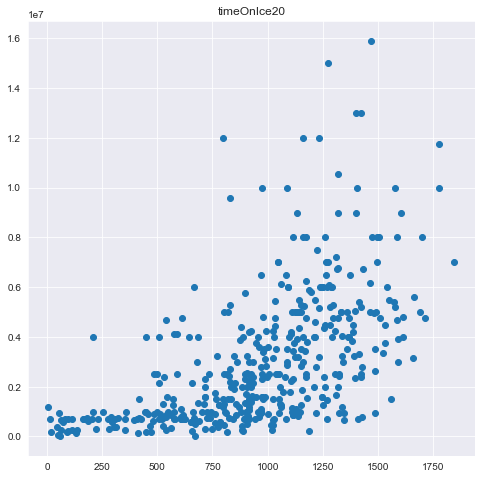

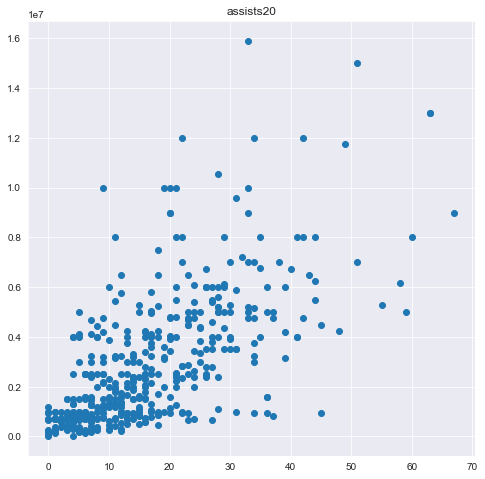

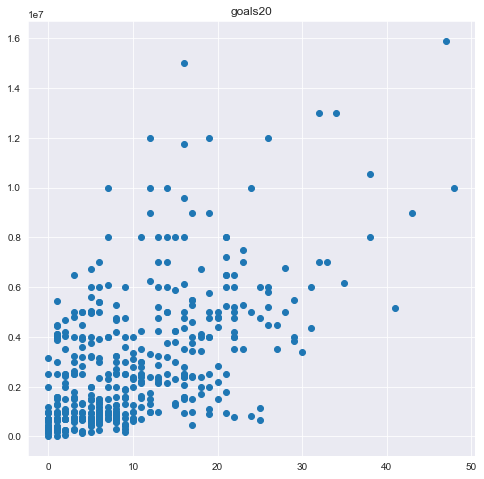

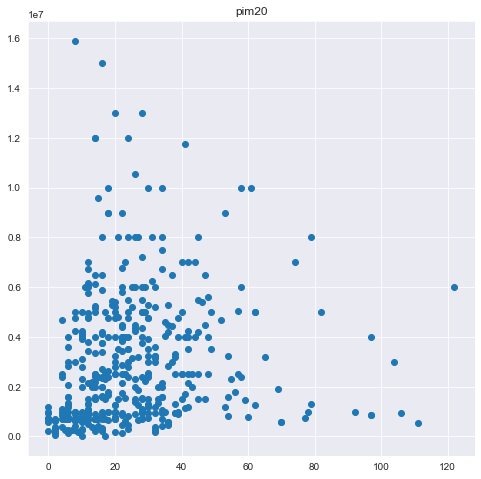

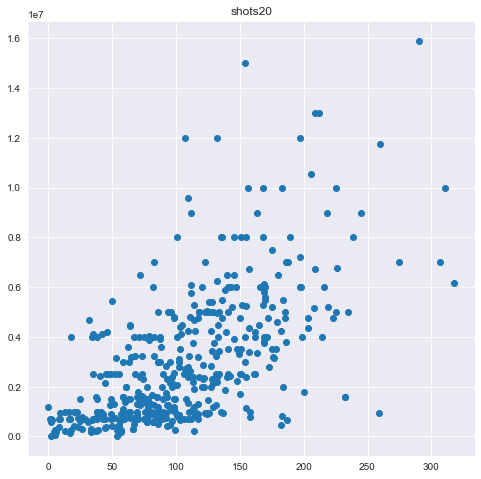

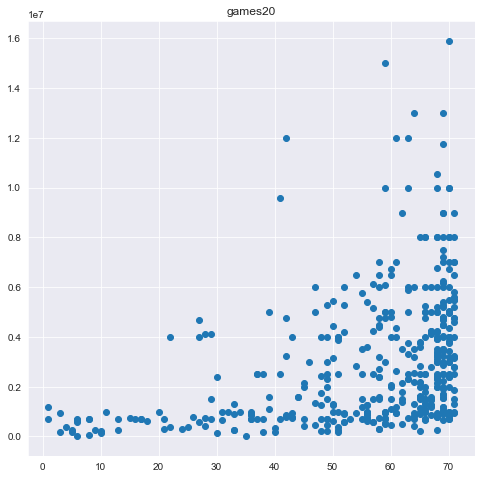

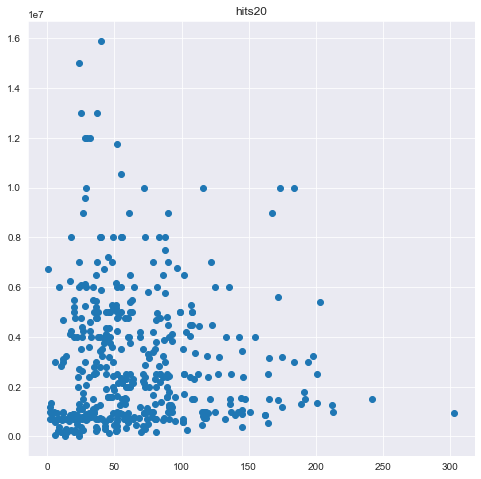

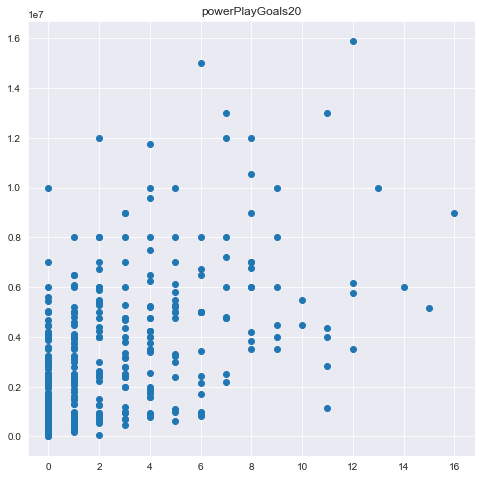

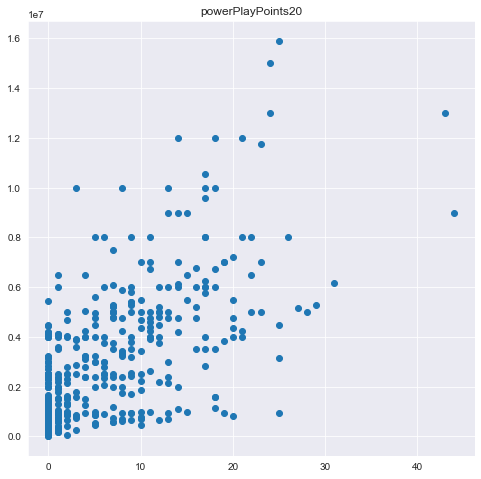

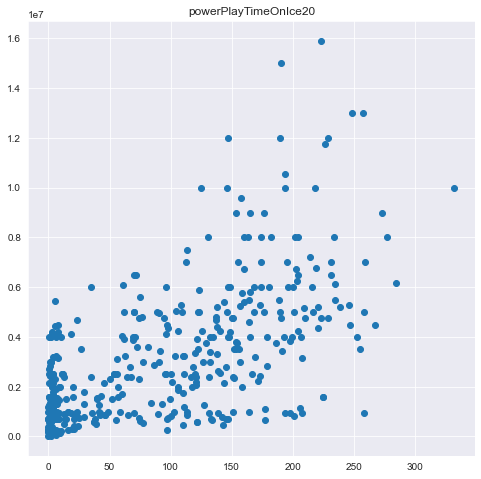

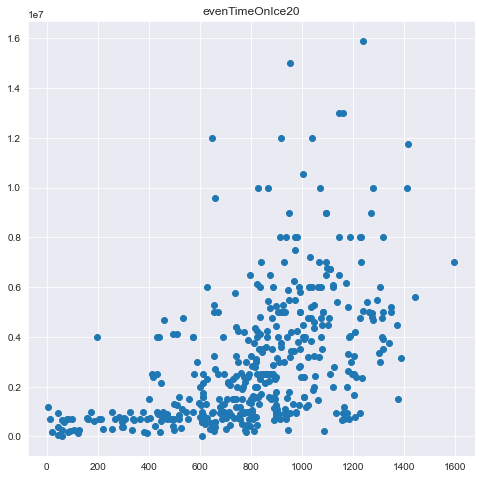

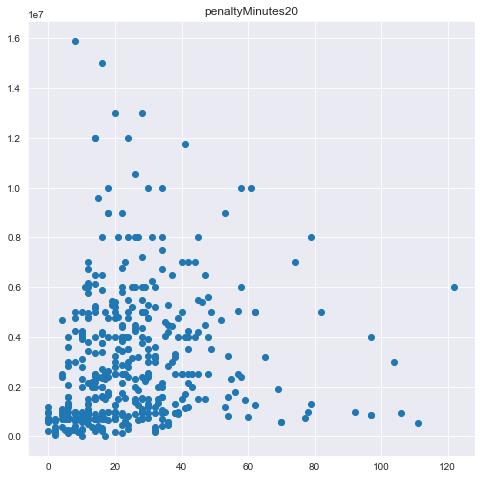

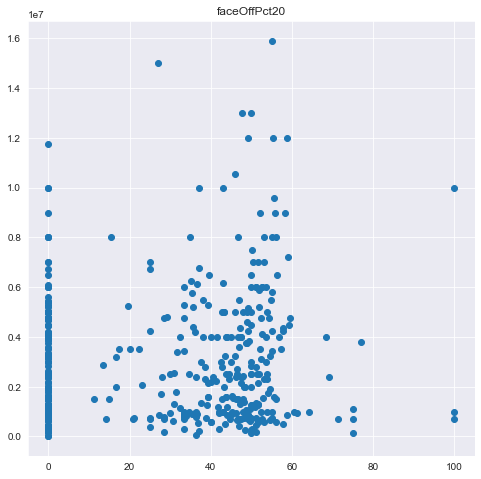

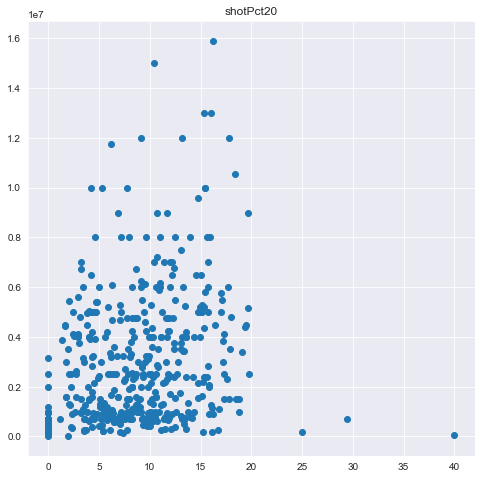

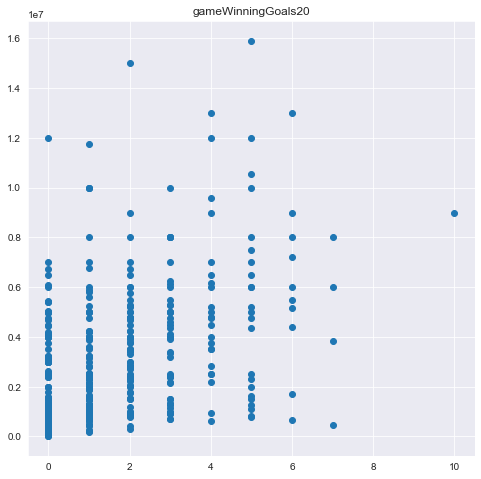

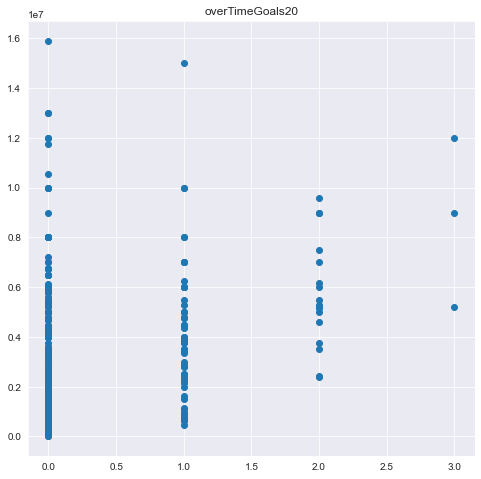

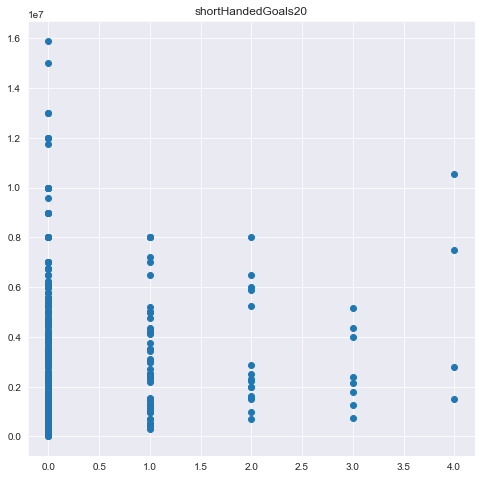

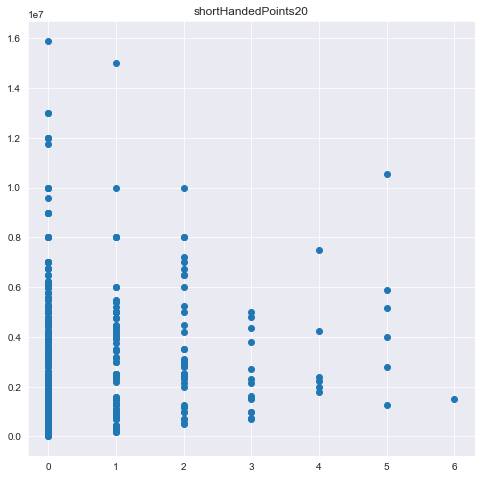

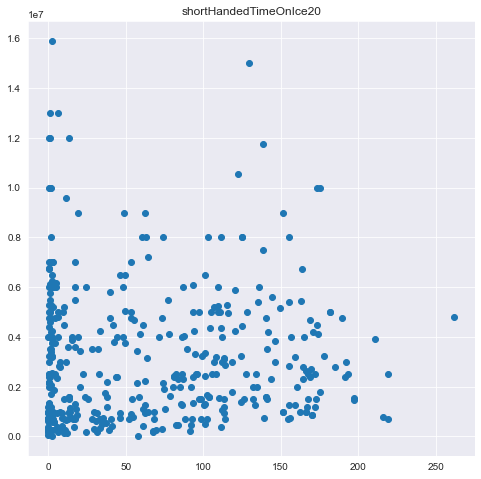

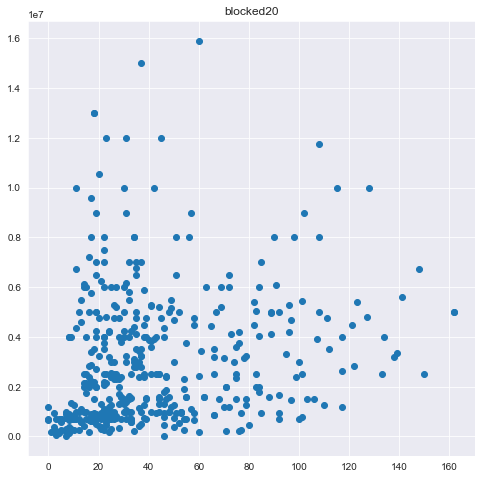

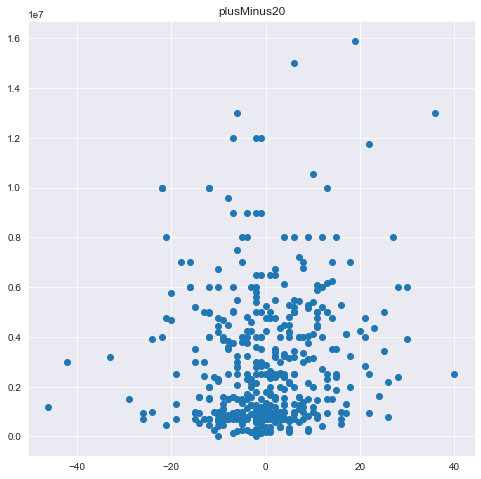

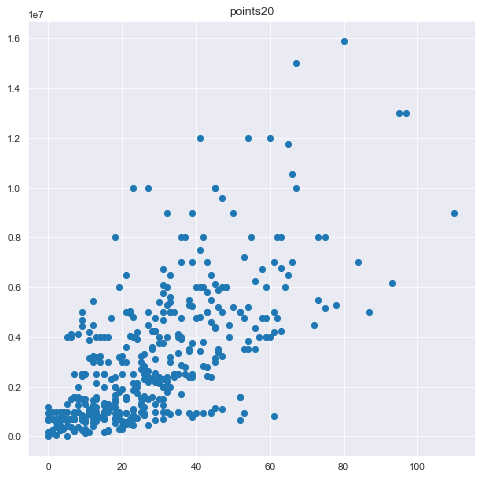

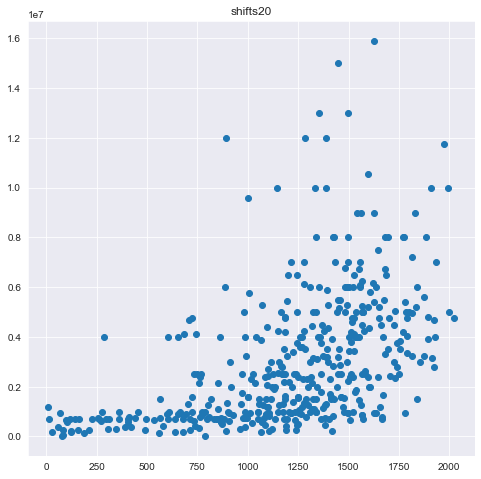

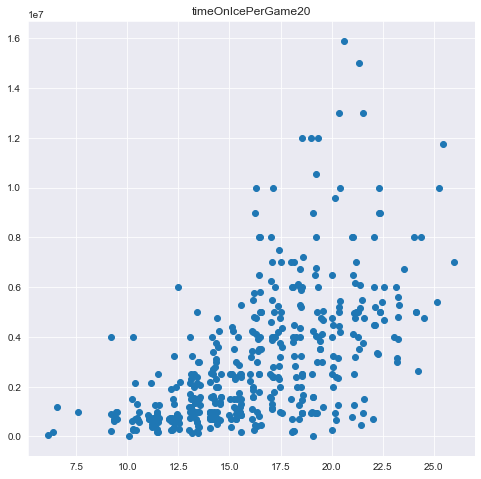

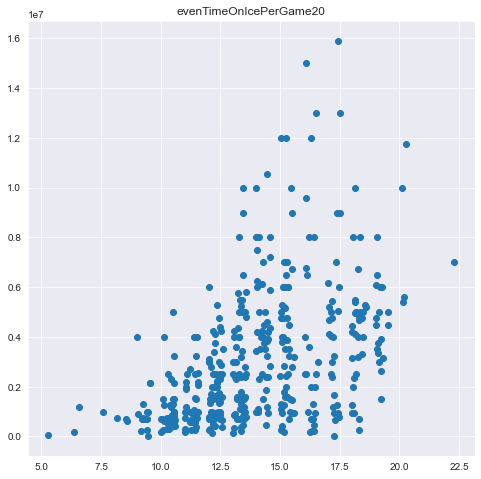

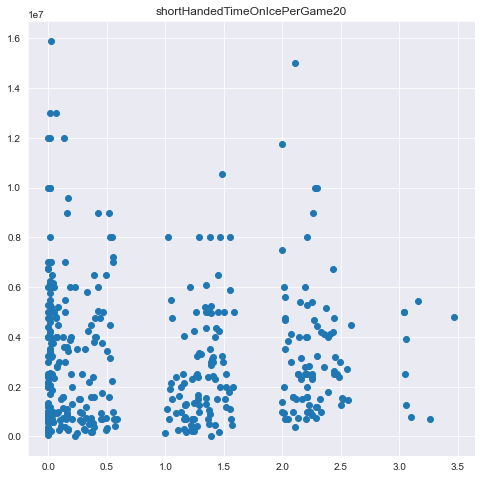

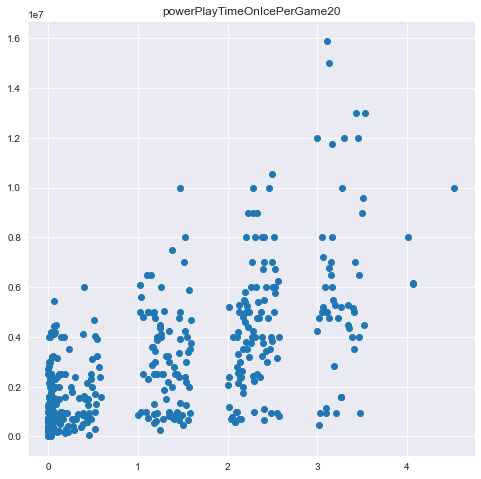

In [69]:
for col in final_df.iloc[:, 15:42].columns:
    fig, ax = plt.subplots(figsize=(8,8))
    plt.scatter(final_df[col], final_df['2020-21'])
    plt.title(col)

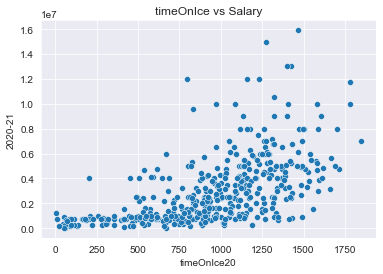

In [70]:
sns.scatterplot(final_df['timeOnIce20'], final_df['2020-21'])
plt.title('timeOnIce vs Salary')
plt.savefig('images/timeOnIce20');

#### Interesting insights, there doesn't seem to be a positive correlation regarding shortHandedTimeOnIce but definite positive correlation between other timeOnIce categories. Excluding timeOnIce the strongest categories showing a positive correlation with salary are points, goals, and assists. 

#### Lets take a look at some of our categorical variables to see if these shows us any other insights.

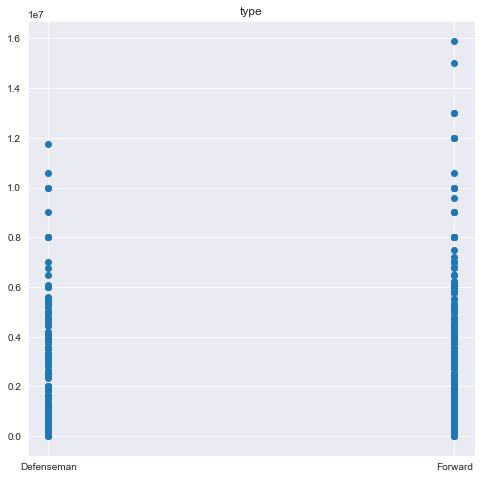

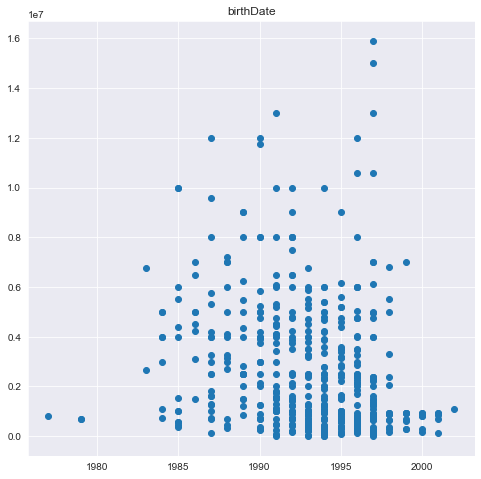

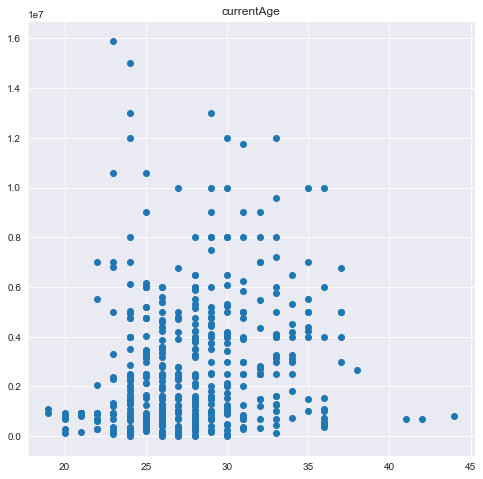

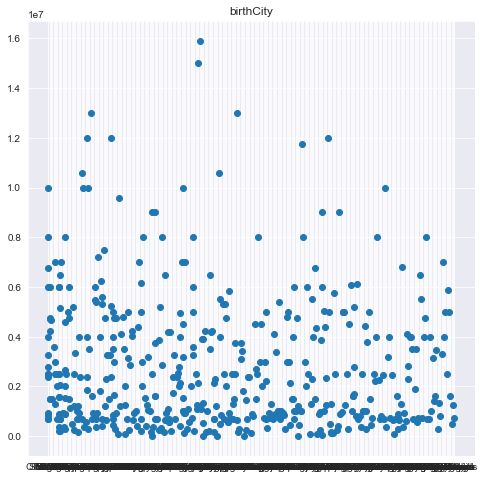

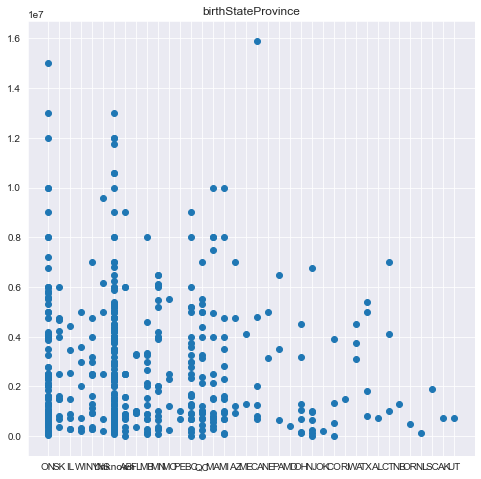

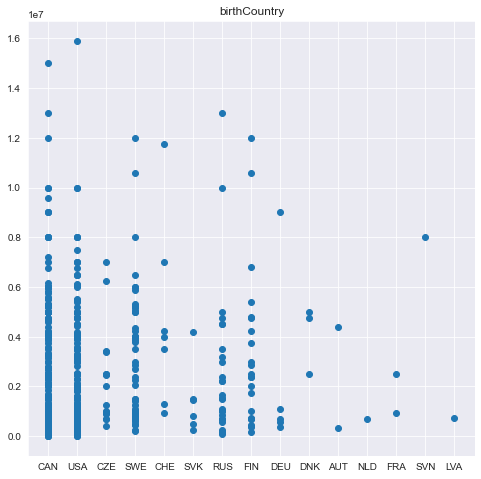

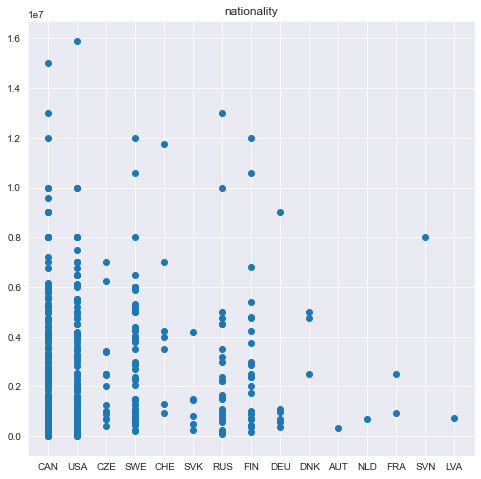

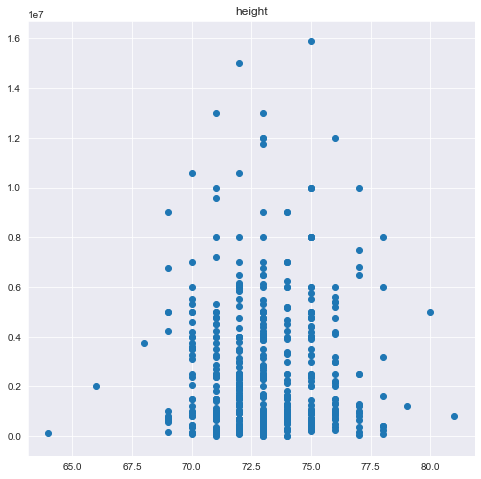

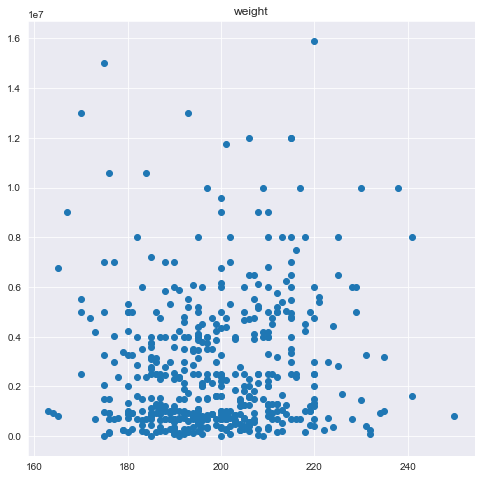

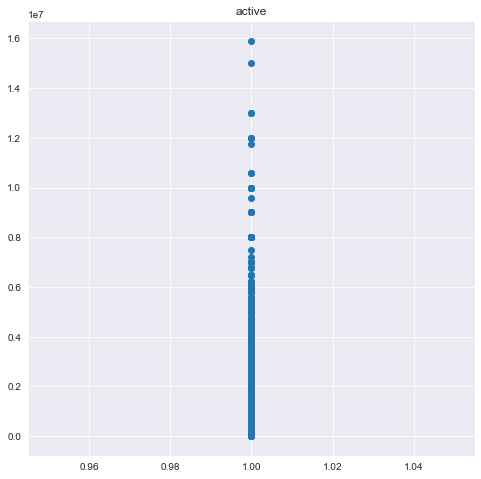

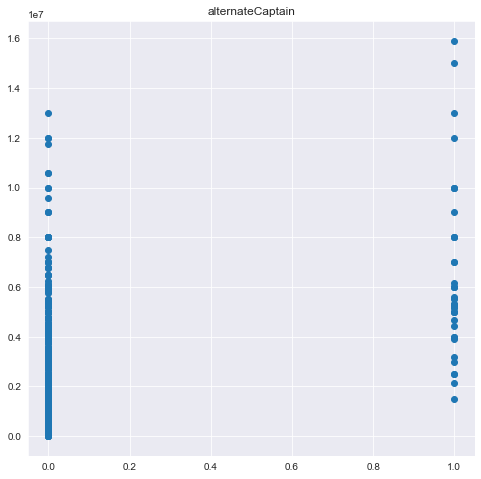

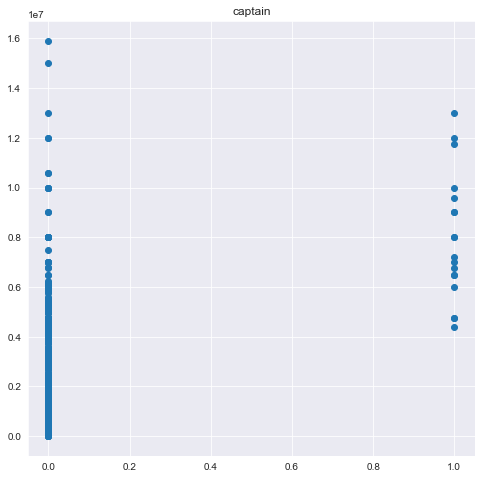

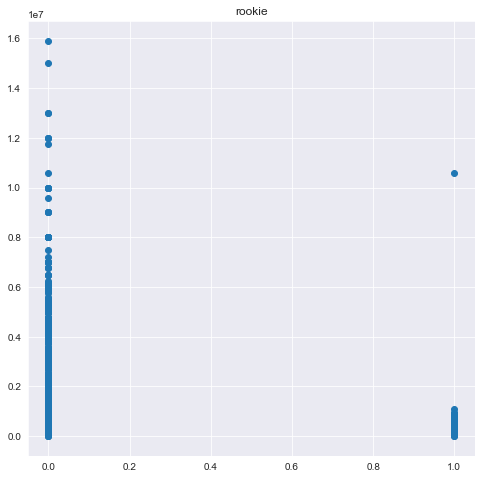

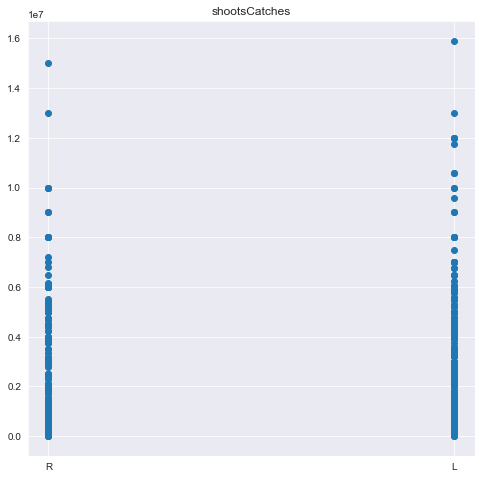

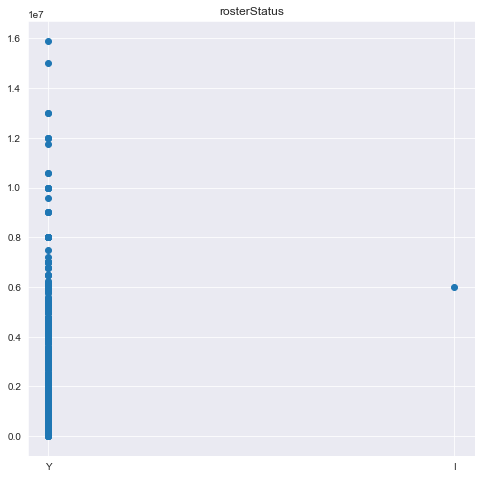

In [71]:
for col in final_df.iloc[:, :15].columns:
    fig, ax = plt.subplots(figsize=(8,8))
    plt.scatter(final_df[col], final_df['2020-21'])
    plt.title(col)

#### This doesn't give us as much information as our numerical values but an interesting observation is that on average left handed shots look to be paid more than right handed shots. Also, it seems on average that US and Canadian nationalities get paid more than other countrys. Lets look at this further.

#### Below we can see that CHE (Switzerland), CHE (Czech), and SWE (Sweden) look to be the highest paid countries based on our top six countries that have a sizeable amount of players in the NHL.  

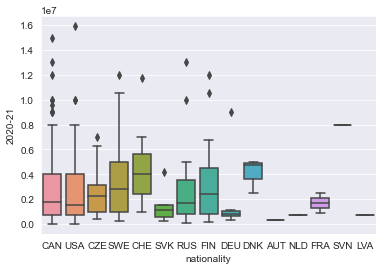

In [72]:
sns.boxplot(final_df['nationality'], final_df['2020-21']);

In [73]:
final_df['nationality'].value_counts()

CAN    198
USA    148
SWE     51
RUS     25
FIN     23
CZE     14
CHE      7
SVK      6
DEU      6
DNK      3
FRA      2
SVN      1
NLD      1
LVA      1
AUT      1
Name: nationality, dtype: int64

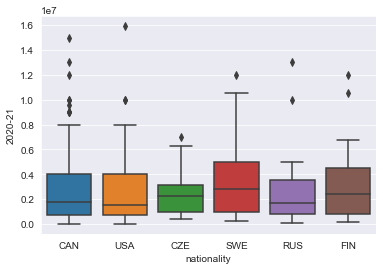

In [74]:
top_count_nations = final_df[final_df['nationality'].isin(['CAN', 'USA', 'SWE', 'RUS', 'FIN', 'CZE'])]
sns.boxplot(top_count_nations['nationality'], top_count_nations['2020-21'])
plt.savefig('images/salaries_boxplot');

In [75]:
top_count_nations.groupby('nationality')['2020-21'].mean().sort_values(ascending=False)

nationality
SWE   3231638.31
FIN   3227613.26
RUS   2774560.68
CAN   2740778.04
USA   2556247.06
CZE   2462207.00
Name: 2020-21, dtype: float64

#### Lets see who the top players are for each country.

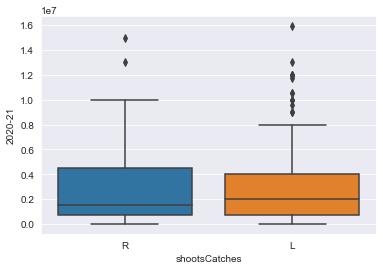

In [76]:
sns.boxplot(final_df['shootsCatches'], final_df['2020-21'])
plt.savefig('images/shootsCatches_boxplot');

In [77]:
final_df.to_csv('cleaned_players_df.csv')
final_df_goalies.to_csv('dirty_goalies_df.csv')

# Modeling

## First Simple Model

### We'll start by importing our saved csv and renaming our year columns. We need to rename our columns going forward in order for the OLS model to perform correctly.

In [78]:
df = pd.read_csv('cleaned_players_df.csv')
df.head()

,Unnamed: 0,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11
0,0,Defenseman,1989,32,Toronto,ON,CAN,CAN,72,210,True,True,False,False,R,Y,1504.25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160.14,1232.41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111.30,90.00,-21.00,18.00,1883.00,22.07,18.07,1.38,2.21,1427.51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163.07,1166.17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98.27,75.00,5.00,31.00,1731.00,22.39,18.30,1.33,2.35,1977.24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253.23,1507.00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217.01,90.00,18.00,59.00,2323.00,24.06,18.22,2.38,3.05,1610.40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172.00,1300.43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137.57,104.00,-8.00,40.00,1860.00,24.24,19.42,2.05,2.36,7000000.00,7000000.00,11000000.00,11000000.00,10000000.00,10000000.00,8000000.00,0.00,0.00,0.00,0.00
1,1,Defenseman,1993,27,Regina,SK,CAN,CAN,73,206,True,False,False,False,L,Y,538.48,7.00,2.00,4.00,32.00,27.00,12.00,0.00,2.00,23.15,460.25,4.00,0.00,6.30,0.00,0.00,0.00,0.00,55.08,50.00,-9.00,9.00,708.00,19.57,17.03,2.02,0.51,1200.36,28.00,1.00,10.00,71.00,56.00,27.00,0.00,1.00,33.43,1025.18,10.00,0.00,1.41,0.00,0.00,0.00,0.00,141.35,93.00,20.00,29.00,1501.00,21.26,18.18,2.31,0.36,811.12,11.00,1.00,8.00,34.00,44.00,31.00,0.00,0.00,12.06,710.11,8.00,0.00,2.94,0.00,0.00,0.00,0.00,88.55,75.00,4.00,12.00,1059.00,18.26,16.08,2.01,0.16,1099.59,9.00,2.00,24.00,52.00,60.00,23.00,0.00,1.00,26.42,960.50,24.00,0.00,3.85,0.00,0.00,0.00,1.00,112.27,96.00,3.00,11.00,1463.00,18.19,16.00,1.52,0.26,0.00,0.00,0.00,0.00,0.00,4500000.00,4700000.00,0.00,0.00,0.00,0.00
2,2,Defenseman,1994,26,Melville,SK,CAN,CAN,74,205,True,True,False,False,R,Y,1584.26,23.00,8.00,52.00,114.00,69.00,81.00,3.00,10.00,137.22,1277.50,52.00,0.00,7.00,2.00,0.00,0.00,0.00,169.14,97.00,-20.00,31.00,1924.00,22.57,18.31,2.27,1.59,1807.31,28.00,11.00,58.00,146.00,82.00,83.00,3.00,12.00,201.51,1483.03,58.00,0.00,7.53,0.00,0.00,0.00,1.00,122.37,87.00,-27.00,39.00,2155.00,22.02,18.05,1.29,2.27,1495.40,15.00,9.00,42.00,121.00,76.00,107.00,0.00,4.00,124.24,1342.30,42.00,0.00,7.44,2.00,0.00,0.00,0.00,28.46,62.00,-8.00,24.

In [79]:
df = df.rename(columns={ '2014-15': 'sal_14_15', '2015-16': 'sal_15_16',\
                         '2016-17': 'sal_16_17', '2017-18': 'sal_17_18',\
                         '2018-19': 'sal_18_19', '2019-20': 'sal_19_20',\
                        '2020-21':'sal_20_21'})
df.head()

,Unnamed: 0,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
0,0,Defenseman,1989,32,Toronto,ON,CAN,CAN,72,210,True,True,False,False,R,Y,1504.25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160.14,1232.41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111.30,90.00,-21.00,18.00,1883.00,22.07,18.07,1.38,2.21,1427.51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163.07,1166.17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98.27,75.00,5.00,31.00,1731.00,22.39,18.30,1.33,2.35,1977.24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253.23,1507.00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217.01,90.00,18.00,59.00,2323.00,24.06,18.22,2.38,3.05,1610.40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172.00,1300.43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137.57,104.00,-8.00,40.00,1860.00,24.24,19.42,2.05,2.36,7000000.00,7000000.00,11000000.00,11000000.00,10000000.00,10000000.00,8000000.00,0.00,0.00,0.00,0.00
1,1,Defenseman,1993,27,Regina,SK,CAN,CAN,73,206,True,False,False,False,L,Y,538.48,7.00,2.00,4.00,32.00,27.00,12.00,0.00,2.00,23.15,460.25,4.00,0.00,6.30,0.00,0.00,0.00,0.00,55.08,50.00,-9.00,9.00,708.00,19.57,17.03,2.02,0.51,1200.36,28.00,1.00,10.00,71.00,56.00,27.00,0.00,1.00,33.43,1025.18,10.00,0.00,1.41,0.00,0.00,0.00,0.00,141.35,93.00,20.00,29.00,1501.00,21.26,18.18,2.31,0.36,811.12,11.00,1.00,8.00,34.00,44.00,31.00,0.00,0.00,12.06,710.11,8.00,0.00,2.94,0.00,0.00,0.00,0.00,88.55,75.00,4.00,12.00,1059.00,18.26,16.08,2.01,0.16,1099.59,9.00,2.00,24.00,52.00,60.00,23.00,0.00,1.00,26.42,960.50,24.00,0.00,3.85,0.00,0.00,0.00,1.00,112.27,96.00,3.00,11.00,1463.00,18.19,16.00,1.52,0.26,0.00,0.00,0.00,0.00,0.00,4500000.00,4700000.00,0.00,0.00,0.00,0.00
2,2,Defenseman,1994,26,Melville,SK,CAN,CAN,74,205,True,True,False,False,R,Y,1584.26,23.00,8.00,52.00,114.00,69.00,81.00,3.00,10.00,137.22,1277.50,52.00,0.00,7.00,2.00,0.00,0.00,0.00,169.14,97.00,-20.00,31.00,1924.00,22.57,18.31,2.27,1.59,1807.31,28.00,11.00,58.00,146.00,82.00,83.00,3.00,12.00,201.51,1483.03,58.00,0.00,7.53,0.00,0.00,0.00,1.00,122.37,87.00,-27.00,39.00,2155.00,22.02,18.05,1.29,2.27,1495.40,15.00,9.00,42.00,121.00,76.00,107.00,0.00,4.00,124.24,1342.30,42.00,0.00,7.44,2.00,0.00,0.00,0.00,28.46,6

In [80]:
formula = 'sal_20_21 ~ goals19'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     240.1
Date:                Mon, 02 Aug 2021   Prob (F-statistic):           4.23e-43
Time:                        17:30:08   Log-Likelihood:                -6701.9
No. Observations:                 419   AIC:                         1.341e+04
Df Residuals:                     417   BIC:                         1.342e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.209e+06    1.6e+05      7.545      0.000    8.94e+05    1.52e+06
goals19     1.561e+05   1.01e+04     15.496      0.000    1.36e+05    1.76e+05
==============================================================================
Omnibus:                       91.353   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.984
Skew:                           1.155   Prob(JB):                     9.18e-42
Kurtosis:                       5.343   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Our R-squared value is 0.365 which is rather low. Hopefully we can improve upon this below.

#### Now, we will identify our categorical columns which will be OneHotEncoded during our modeling. 

In [81]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [82]:
df_cat_cols = ['type', 'birthCity', 'birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus', 'nationality', 'active']
df_no_cats = df.drop(df_cat_cols, axis=1)
df_no_cats.head()

,birthDate,currentAge,height,weight,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
0,1989,32,72,210,1504.25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160.14,1232.41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111.30,90.00,-21.00,18.00,1883.00,22.07,18.07,1.38,2.21,1427.51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163.07,1166.17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98.27,75.00,5.00,31.00,1731.00,22.39,18.30,1.33,2.35,1977.24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253.23,1507.00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217.01,90.00,18.00,59.00,2323.00,24.06,18.22,2.38,3.05,1610.40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172.00,1300.43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137.57,104.00,-8.00,40.00,1860.00,24.24,19.42,2.05,2.36,7000000.00,7000000.00,11000000.00,11000000.00,10000000.00,10000000.00,8000000.00,0.00,0.00,0.00,0.00
1,1993,27,73,206,538.48,7.00,2.00,4.00,32.00,27.00,12.00,0.00,2.00,23.15,460.25,4.00,0.00,6.30,0.00,0.00,0.00,0.00,55.08,50.00,-9.00,9.00,708.00,19.57,17.03,2.02,0.51,1200.36,28.00,1.00,10.00,71.00,56.00,27.00,0.00,1.00,33.43,1025.18,10.00,0.00,1.41,0.00,0.00,0.00,0.00,141.35,93.00,20.00,29.00,1501.00,21.26,18.18,2.31,0.36,811.12,11.00,1.00,8.00,34.00,44.00,31.00,0.00,0.00,12.06,710.11,8.00,0.00,2.94,0.00,0.00,0.00,0.00,88.55,75.00,4.00,12.00,1059.00,18.26,16.08,2.01,0.16,1099.59,9.00,2.00,24.00,52.00,60.00,23.00,0.00,1.00,26.42,960.50,24.00,0.00,3.85,0.00,0.00,0.00,1.00,112.27,96.00,3.00,11.00,1463.00,18.19,16.00,1.52,0.26,0.00,0.00,0.00,0.00,0.00,4500000.00,4700000.00,0.00,0.00,0.00,0.00
2,1994,26,74,205,1584.26,23.00,8.00,52.00,114.00,69.00,81.00,3.00,10.00,137.22,1277.50,52.00,0.00,7.00,2.00,0.00,0.00,0.00,169.14,97.00,-20.00,31.00,1924.00,22.57,18.31,2.27,1.59,1807.31,28.00,11.00,58.00,146.00,82.00,83.00,3.00,12.00,201.51,1483.03,58.00,0.00,7.53,0.00,0.00,0.00,1.00,122.37,87.00,-27.00,39.00,2155.00,22.02,18.05,1.29,2.27,1495.40,15.00,9.00,42.00,121.00,76.00,107.00,0.00,4.00,124.24,1342.30,42.00,0.00,7.44,2.00,0.00,0.00,0.00,28.46,62.00,-8.00,24.00,1904.00,19.40,17.39,0.22,1.38,1628.11,28.00,3.00,58.00,125.00,80.00,79.00,0.00,13.00,181.27,1421.30,58.00,0.00,2.40,1.00,0.00,0.00,0.00,25.14,73.00,-31.00,31.00,2091.00,20.21,17.46,0.18,2.16,0.00,0.00,0.00,2500000.00,3000000.00,4675000.00,4675000.00,0.00,0.00,0.00,0.00
3,1994,27,71,192,417.53,

#### Prior to building our Linear Regression Model we will need to verify that the assumptions are in place. First we will verify that our data is normally distributed or if we will need to incorporate some form of scaling within our model building process.

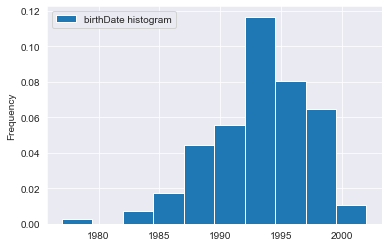

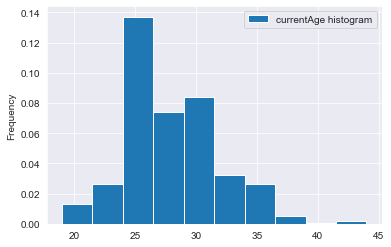

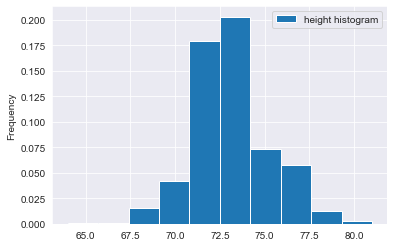

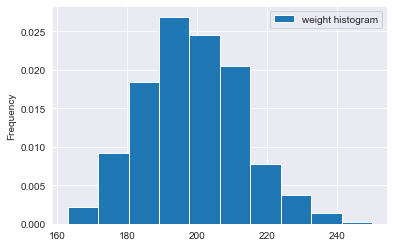

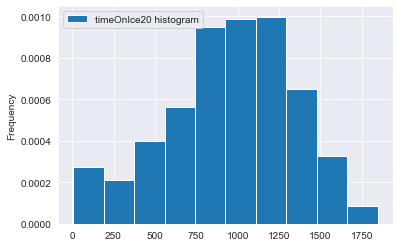

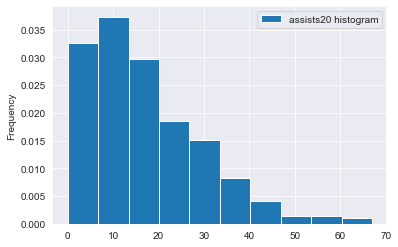

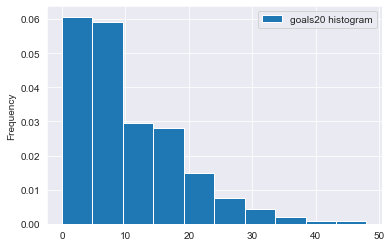

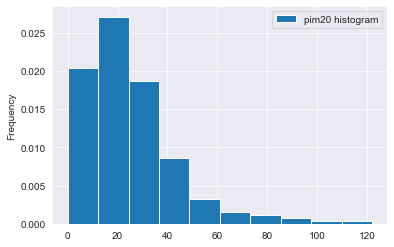

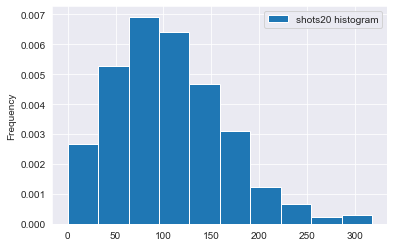

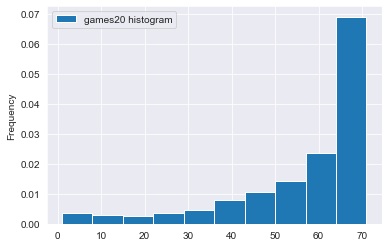

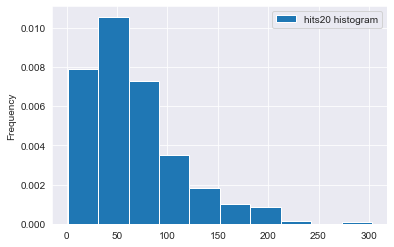

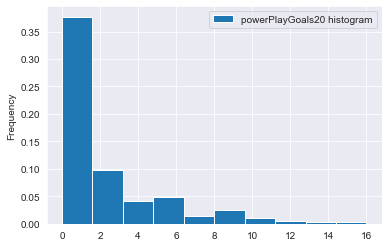

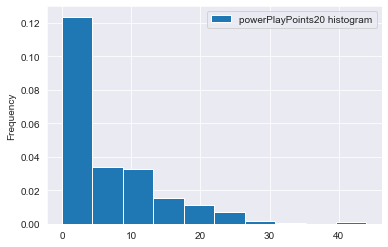

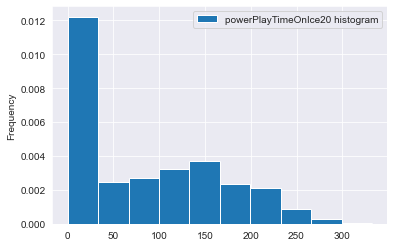

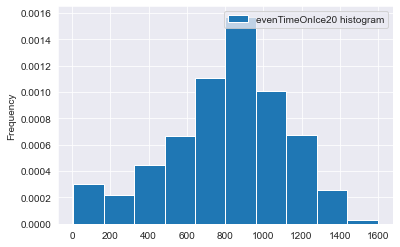

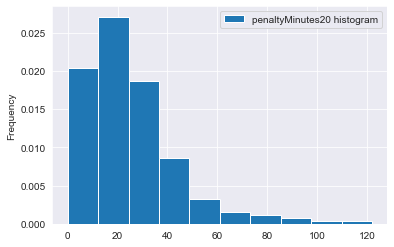

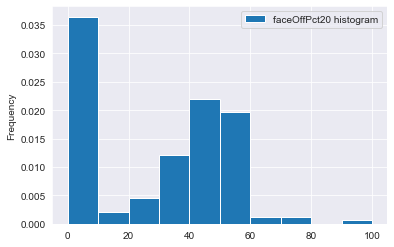

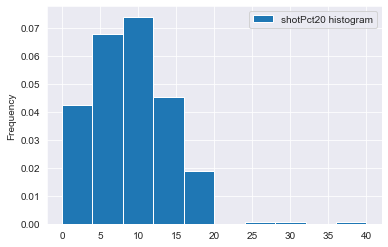

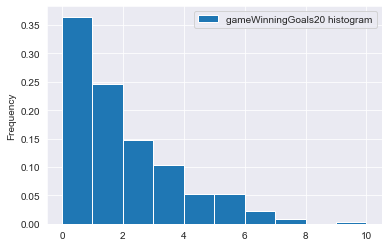

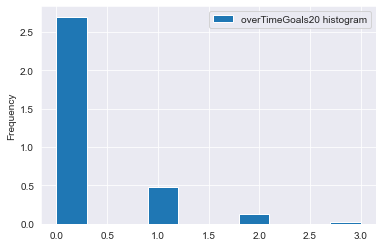

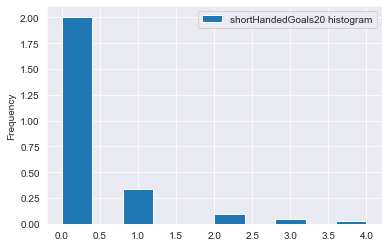

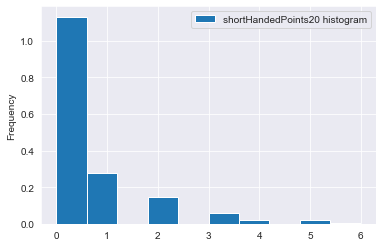

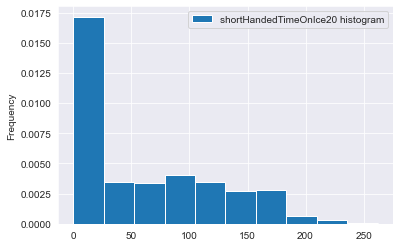

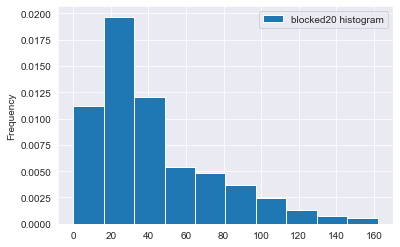

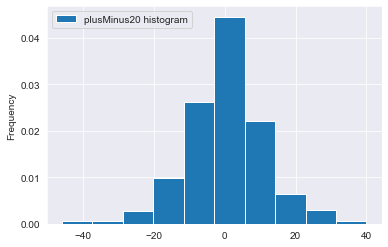

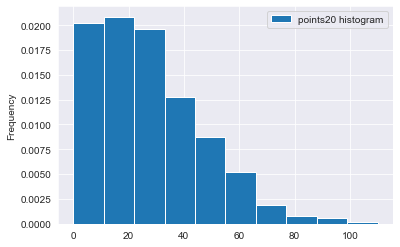

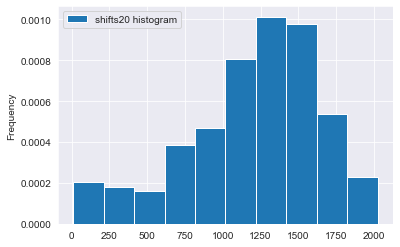

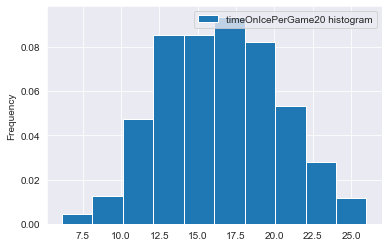

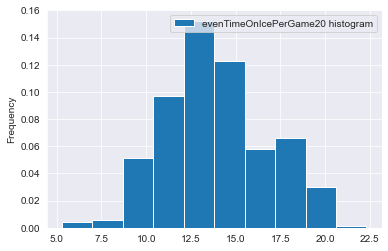

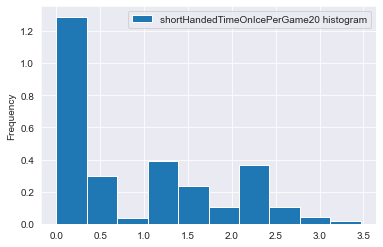

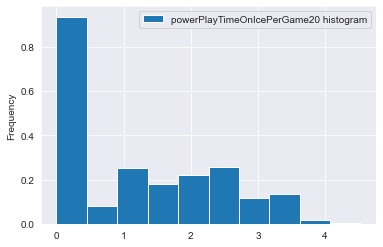

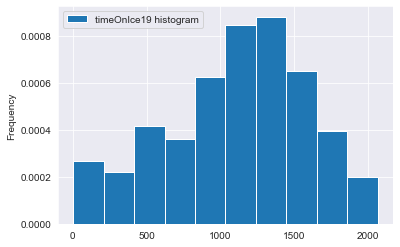

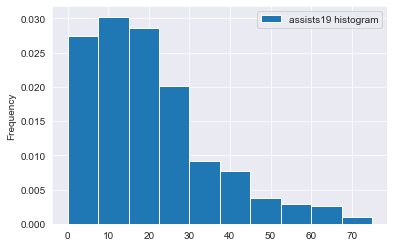

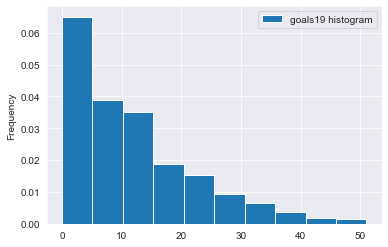

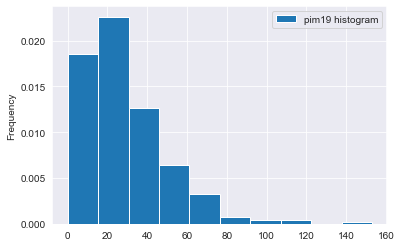

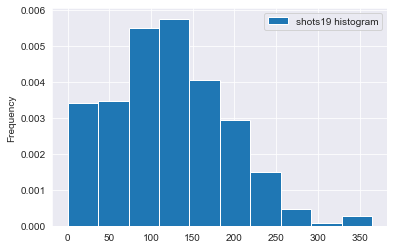

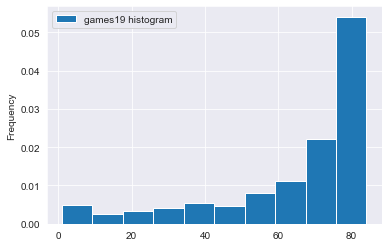

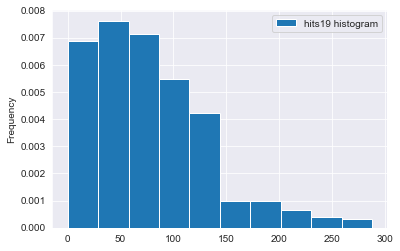

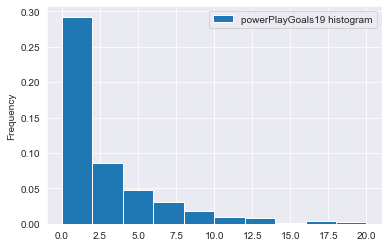

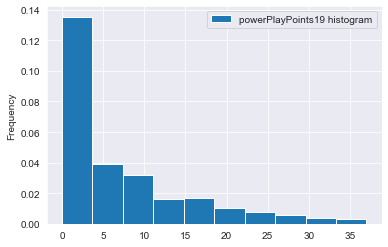

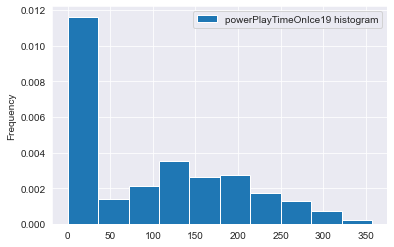

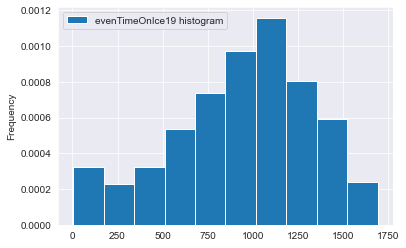

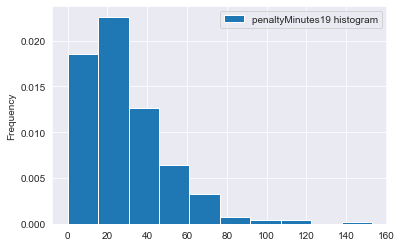

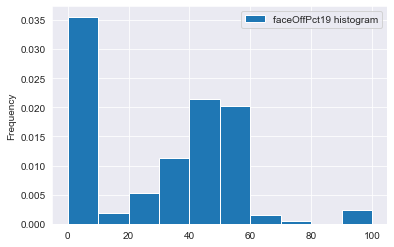

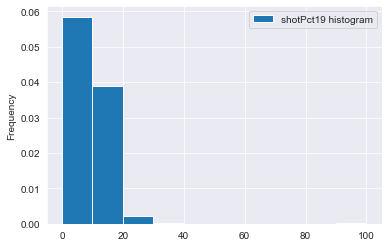

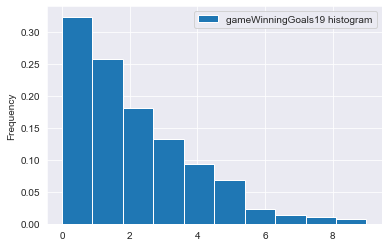

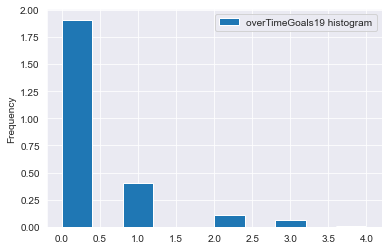

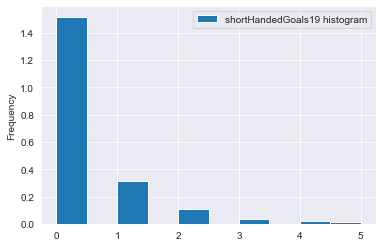

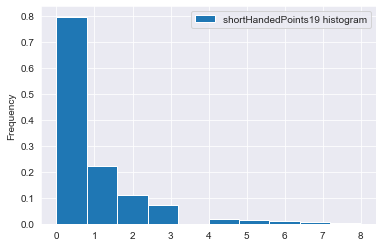

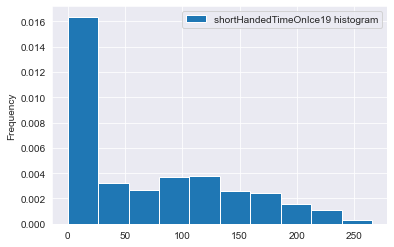

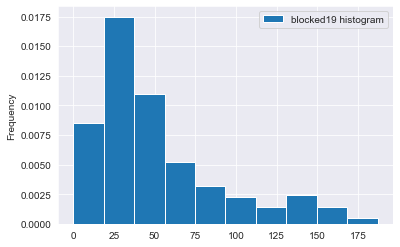

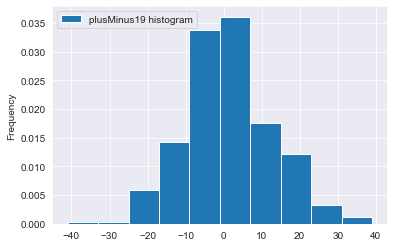

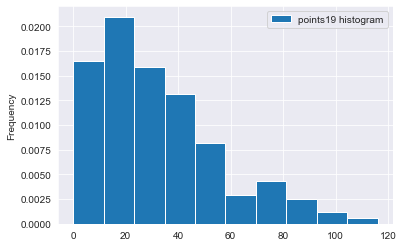

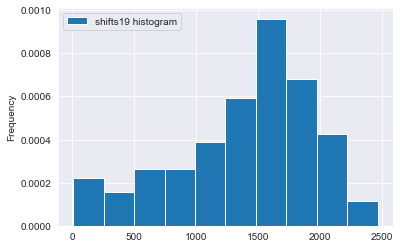

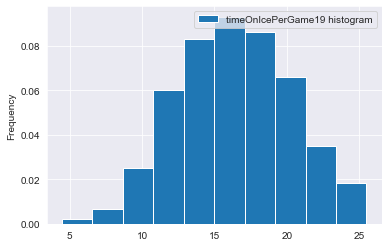

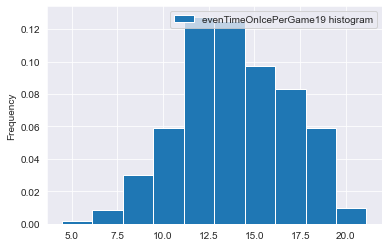

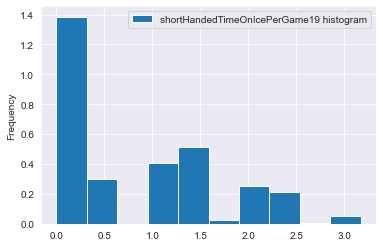

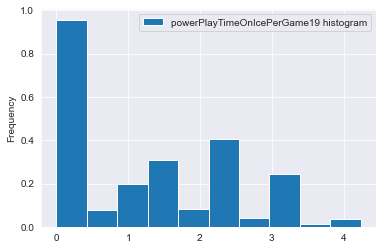

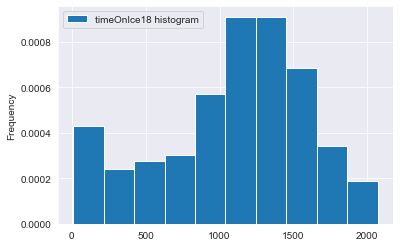

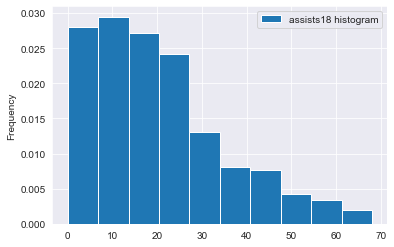

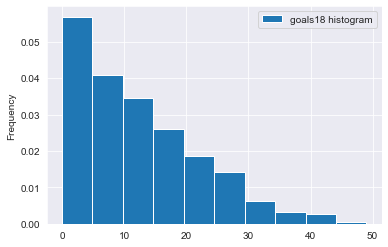

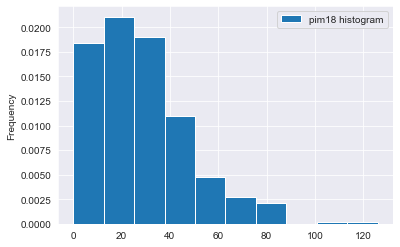

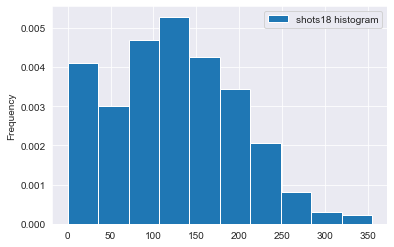

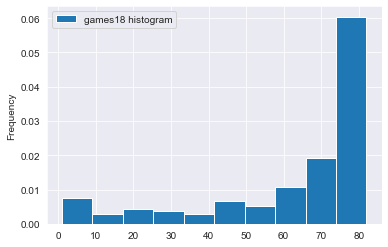

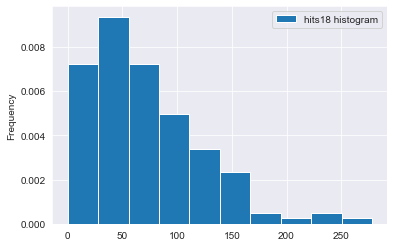

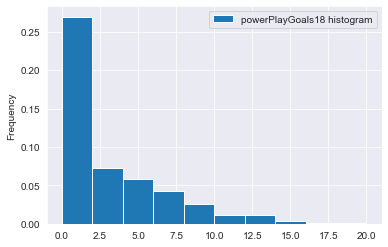

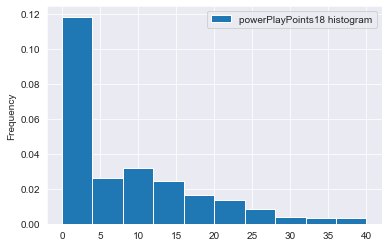

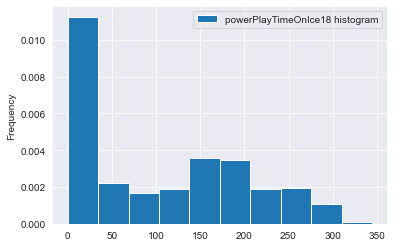

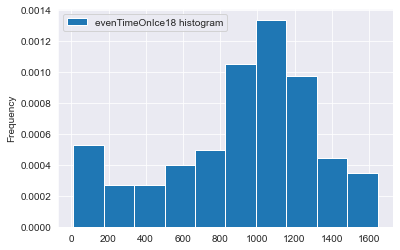

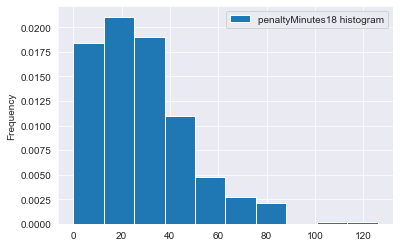

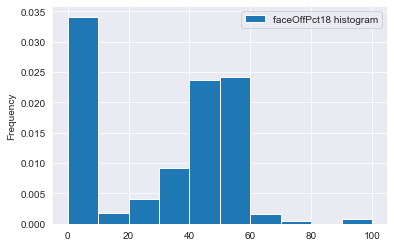

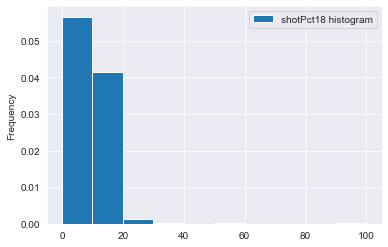

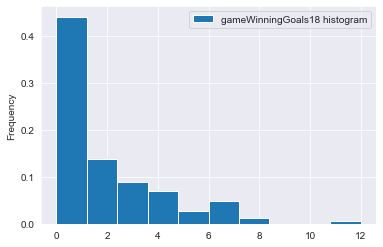

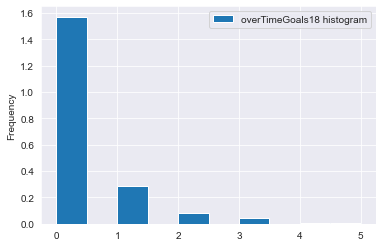

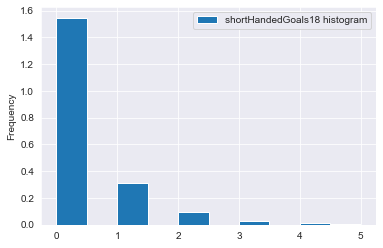

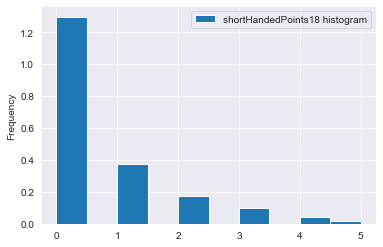

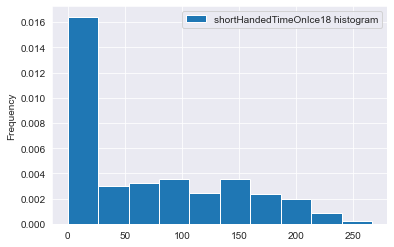

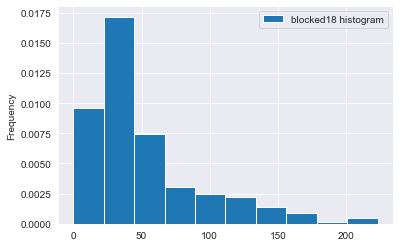

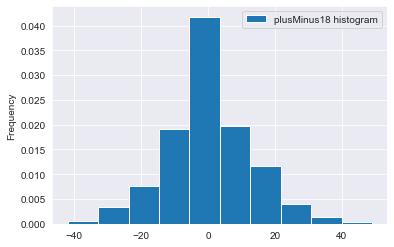

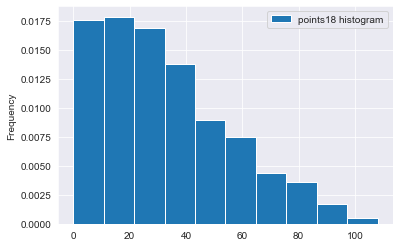

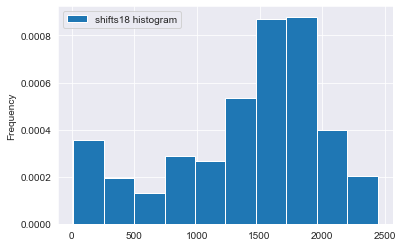

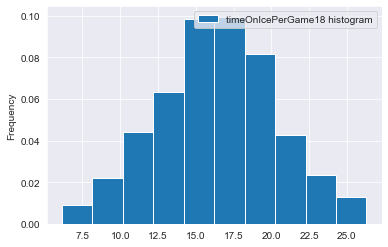

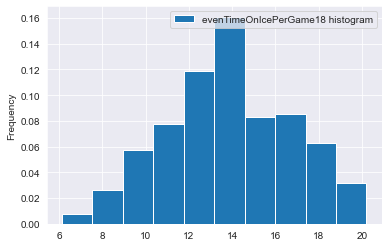

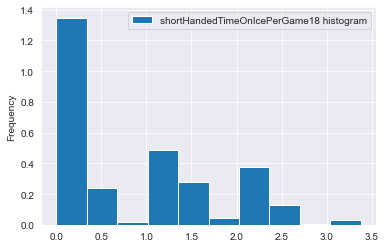

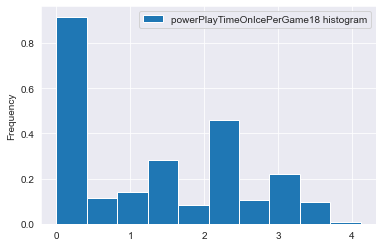

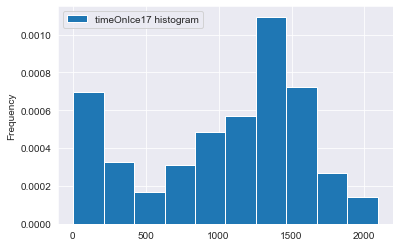

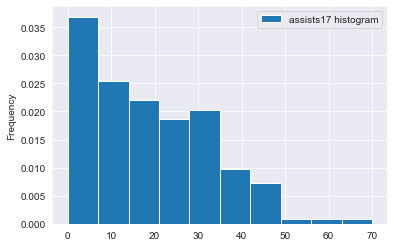

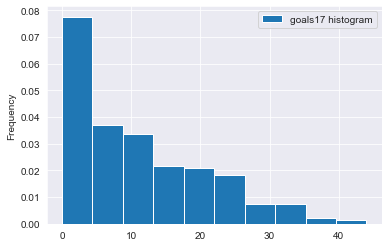

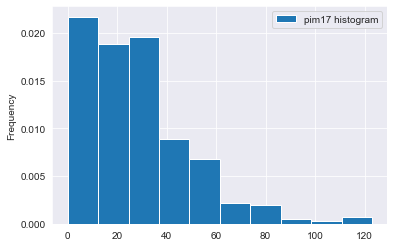

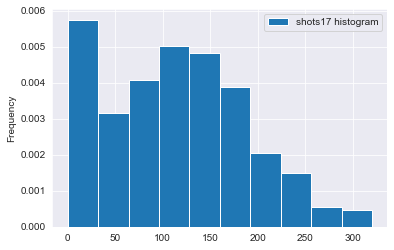

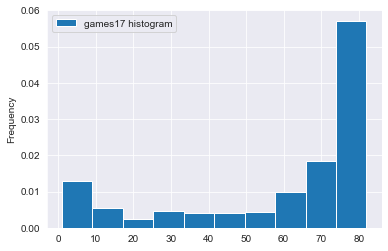

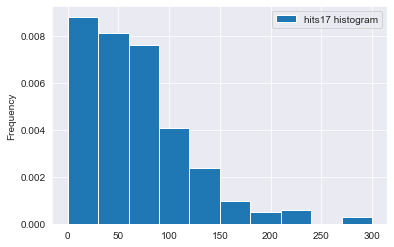

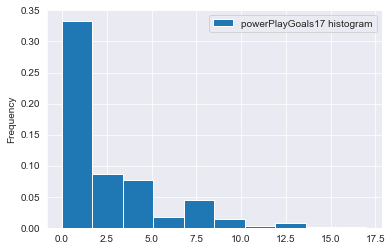

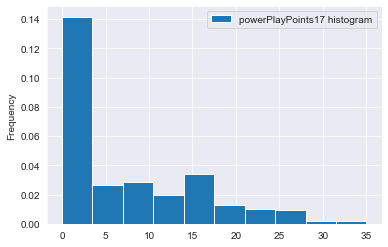

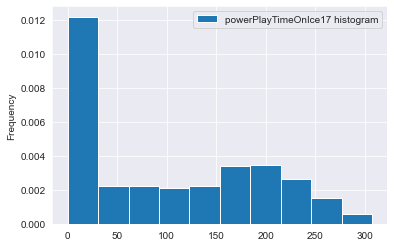

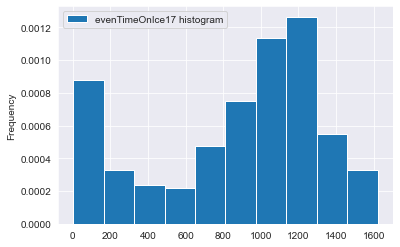

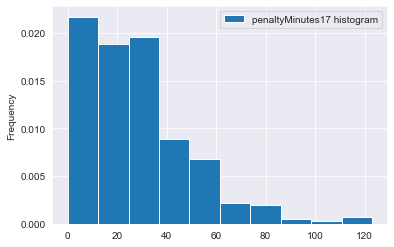

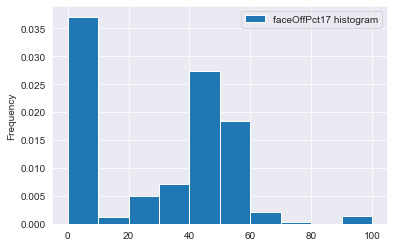

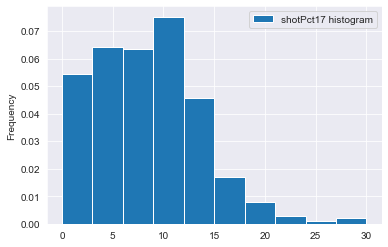

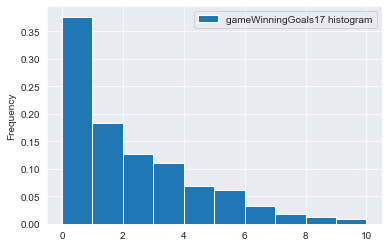

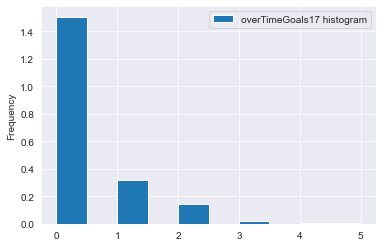

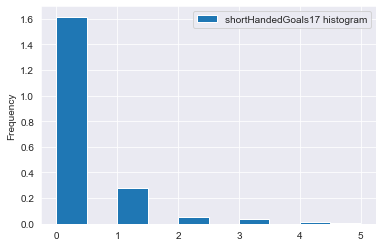

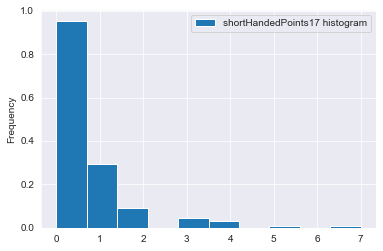

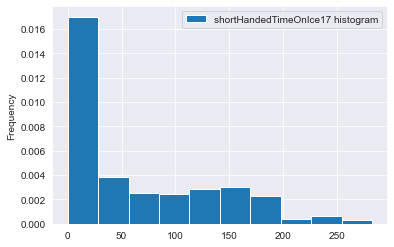

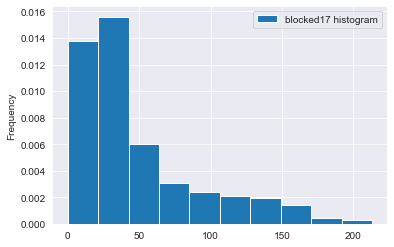

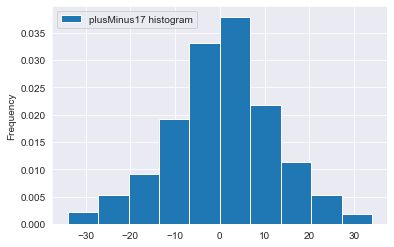

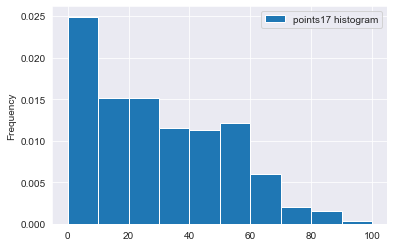

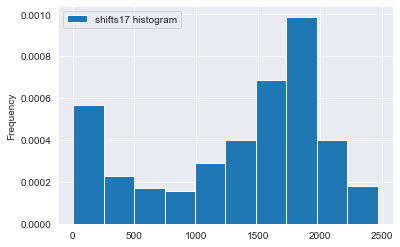

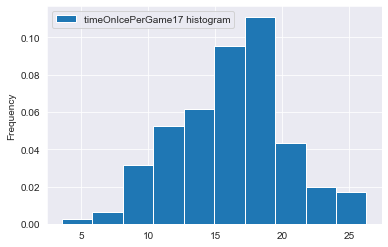

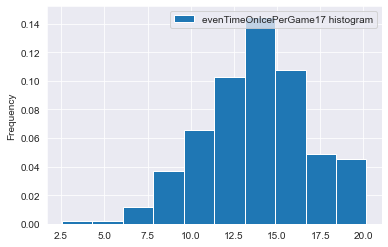

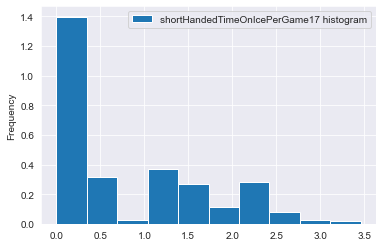

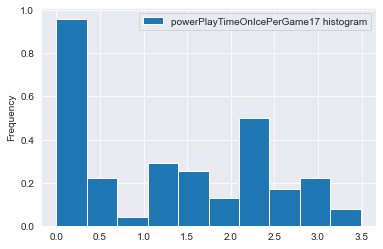

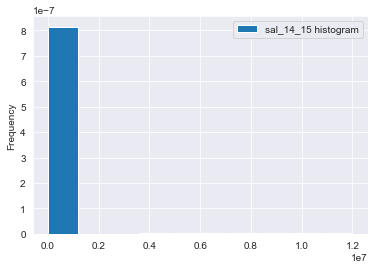

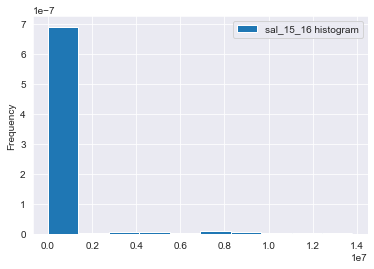

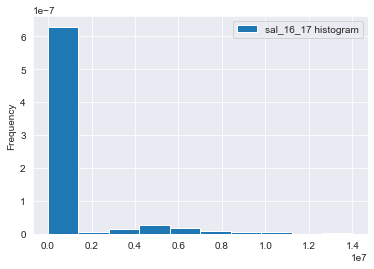

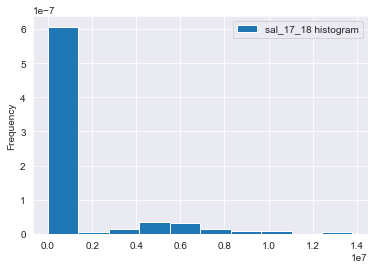

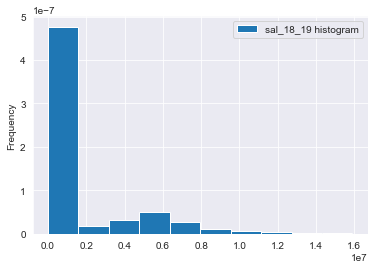

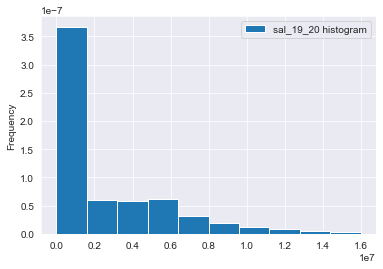

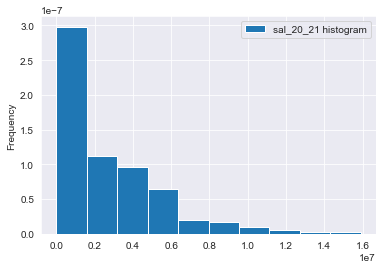

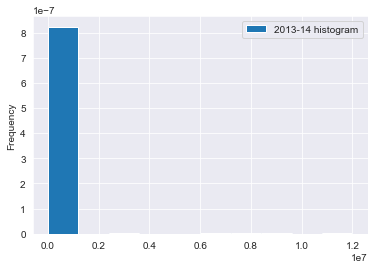

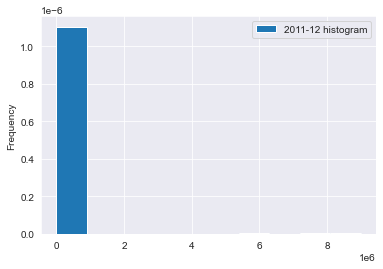

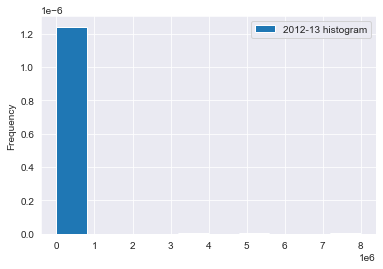

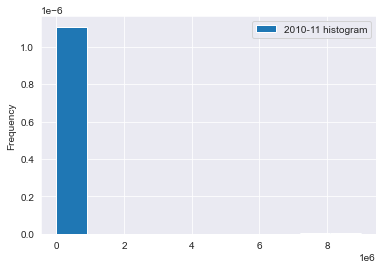

In [83]:
for column in df_no_cats.columns:
    df_no_cats[column].plot.hist(density=True, label = column+' histogram')
    plt.legend()
    plt.show()

#### Reviewing the above charts we can see that our data is not normally distributed and we will need to incorporatre some form a scaling. Another method to indicate this issue is by calling the describe function on our dataframe. Below we can see that our values are drastically different within a column and accross the dataframe. Moving forward we will use a standardscaler in our pipeline. 

In [84]:
df_no_cats.describe()

,birthDate,currentAge,height,weight,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
count,487.00,487.00,487.00,487.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00
mean,1992.97,27.68,73.08,198.90,953.40,17.01,10.32,25.53,105.41,56.13,66.88,2.13,6.16,85.21,807.57,25.53,28.70,8.94,1.55,0.24,0.30,0.59,60.27,42.42,0.22,27.33,1201.93,16.30,13.90,0.89,1.23,1102.66,20.01,12.04,28.75,120.96,64.47,78.15,2.31,6.88,99.38,934.02,28.75,29.94,9.11,1.91,0.35,0.38,0.74,68.87,51.15,0.67,32.05,1397.11,16.32,13.93,0.84,1.25,1089.94,20.08,12.12,28.14,123.56,63.06,71.02,2.79,7.95,104.95,915.63,28.14,30.35,9.15,1.93,0.32,0.33,0.63,69.00,51.40,0.64,32.20,1396.08,16.31,13.85,0.86,1.33,1038.21,18.30,10.93,27.64,113.13,59.37,67.46,2.37,7.15,102.28,872.27,27.64,28.90,8.32,1.85,0.36,0.28,0.58,63.31,47.36,0.29,29.23,1344.25,16.18,13.78,0.79,1.30,179876.80,322818.28,719342.92,1017555.67,1462161.45,2395959.95,2758682.47,92710.47,47227.93,34757.35,34907.60
std,3.94,3.91,2.14,14.36,385.64,12.48,8.67,18.88,58.50,16.78,46.82,3.00,7.46,81.09,309.76,18.88,23.98,5.17,1.74,0.55,0.71,1.07,61.94,32.13,10.88,19.37,441.56,3.78,2.86,0.92,1.17,484.40,15.12,10.42,21.68,68.84,21.70,55.84,3.42,8.52,93.79,389.83,21.68,25.31,6.92,1.94,0.73,0.81,1.30,70.82,40.75,11.88,23.62,566.59,3.94,2.97,0.87,1.16,507.87,15.19,10.20,20.02,73.16,23.40,51.59,3.61,9.20,94.59,407.36,20.02,24.01,7.27,2.17,0.73,0.72,1.05,71.16,42.86,12.54,23.54,611.35,3.99,2.92,0.89,1.16,562.55,14.29,9.70,21.96,74.09,26.93,53.17,3.09,8.06,91.91,455.14,21.96,24.53,5.42,2.12,0.72,0.70,1.09,

#### Next lets get create a Linear Regression model with only our numerical features. 

# Modeling

#### Train Test Split No Categoricals

In [85]:
# df_no_cats = df.drop(df_cat_cols, axis=1)

X = df_no_cats.drop('sal_20_21', axis=1)
y = df_no_cats['sal_20_21']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X,y, random_state=42)

In [86]:
y_train_num.describe()

count        365.00
mean     2755790.51
std      2703943.21
min         6034.00
25%       735000.00
50%      1600000.00
75%      4200000.00
max     15910000.00
Name: sal_20_21, dtype: float64

#### Baseline Linear Regression Model

In [87]:
numeric_features = X_train_num.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

clf.fit(X_train_num, y_train_num)
print("model train score: %.3f" % clf.score(X_train_num, y_train_num))
print("model test score: %.3f" % clf.score(X_test_num, y_test_num))


train_yhat = clf.predict(X_train_num)
test_yhat = clf.predict(X_test_num)

train_rmse = np.sqrt(mean_squared_error(y_train_num, train_yhat))
test_rmse = np.sqrt(mean_squared_error(y_test_num, test_yhat))

print(f'train rmse: {train_rmse}')
print(f'test rmse: {test_rmse}')

model train score: 0.876
model test score: -5585316840090409407348736.000
train rmse: 949620.5500596225
test rmse: 6.053958282784772e+18


#### With a score of -infinity there is defnitely room for improvement. Lets take a look at our correlations and filter out any highly correlated columns.

#### Below we will filter our dataframes based on columns that have colinearity value of less than .7.

In [88]:
X_train_num.drop(['2010-11', '2012-13', '2011-12', '2013-14', 'sal_14_15', 'sal_15_16', 'sal_16_17',\
                 'sal_17_18'], axis=1, inplace=True)

In [89]:
correlated_features = set()
correlation_matrix = X_train_num.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.70:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_train_num.drop(labels=correlated_features, axis=1, inplace=True)
X_test_num.drop(labels=correlated_features, axis=1, inplace=True)

In [90]:
df_corr=X_train_num.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head()

,cc
pairs,
"(faceOffPct19, faceOffPct20)",0.69
"(faceOffPct17, faceOffPct20)",0.69
"(timeOnIce19, timeOnIce20)",0.67
"(sal_19_20, sal_18_19)",0.67
"(hits18, hits17)",0.66


#### Below we take a look at our updated features. As seen above goals and time on ice had a strong positive correlation with salary. Also, I assume that age/birthDate may have an effect on our model building. We wil continue with our linear regression model to see if we can get an increase in model performace. 

In [91]:
X_train_num.columns.tolist()

['birthDate',
 'height',
 'timeOnIce20',
 'goals20',
 'pim20',
 'hits20',
 'faceOffPct20',
 'shotPct20',
 'overTimeGoals20',
 'shortHandedGoals20',
 'shortHandedTimeOnIce20',
 'blocked20',
 'plusMinus20',
 'timeOnIce19',
 'pim19',
 'faceOffPct19',
 'shotPct19',
 'overTimeGoals19',
 'shortHandedGoals19',
 'plusMinus19',
 'pim18',
 'hits18',
 'shotPct18',
 'shortHandedGoals18',
 'plusMinus18',
 'pim17',
 'hits17',
 'faceOffPct17',
 'shotPct17',
 'overTimeGoals17',
 'shortHandedGoals17',
 'plusMinus17',
 'sal_18_19',
 'sal_19_20']

In [92]:
numeric_features = X_train_num.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])


clf.fit(X_train_num, y_train_num)
print("model train score: %.3f" % clf.score(X_train_num, y_train_num))
print("model test score: %.3f" % clf.score(X_test_num, y_test_num))

train_yhat = clf.predict(X_train_num)
test_yhat = clf.predict(X_test_num)

train_rmse = np.sqrt(mean_squared_error(y_train_num, train_yhat))
test_rmse = np.sqrt(mean_squared_error(y_test_num, test_yhat))

print(f'train rmse: {train_rmse}')
print(f'test rmse: {test_rmse}')

model train score: 0.776
model test score: 0.625
train rmse: 1276683.5013176738
test rmse: 1568798.7752676385


#### Our test score jumped by an incredible amount. Next we will add in our categorical columns to see if that makes a difference. 

#### We will start by creating a new dataframe with our selected features and categorical features and joining it with the categorical features selected from before.

In [93]:
df_w_cats = pd.concat([X, df[df_cat_cols]], axis=1)
df_w_cats = pd.concat([df_w_cats, y], axis=1)

### Train Test Split With Categoricals

In [94]:
X_cat = df_w_cats.drop('sal_20_21', axis=1)
y_cat = df_w_cats['sal_20_21']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, random_state=42)

#### We start adding categoricals by getting every possible combination of columns. 

In [95]:
total_combos = []
data = df_cat_cols
for col in range(0, len(data)+1):
    for subset in combinations(data, col):
        total_combos.append(subset)

#### Next we iterate over our pipeline with our column cobination storing our RMSE and R2 values in separate dictionaries. We will use these values to see if any combination brings an increase to our model. 

In [96]:
cat_scores_rmse = {}
cat_scores_r2 = {}

for i in range(len(total_combos)):
    
    for num, val in enumerate(total_combos):
        
        if num == i:
            
            cat = df[list(val)]
                
            numeric_features = X_train_cat.select_dtypes(['int', 'float']).columns.tolist()


            numeric_transformer = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])

            categorical_features = cat.columns.tolist()

            categorical_transformer = OneHotEncoder(handle_unknown='ignore')

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)])

            # Append classifier to preprocessing pipeline.
            # Now we have a full prediction pipeline.
            clf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LinearRegression())])

            clf.fit(X_train_cat, y_train_cat)

            yhat = clf.predict(X_test_cat)

            cat_scores_rmse[i] = np.sqrt(mean_squared_error(y_test_cat, yhat))
            cat_scores_r2[i] = clf.score(X_test_cat, y_test_cat)

In [97]:
minval_rmse = min(cat_scores_rmse.values())
minval_rmse

1955672.5686956886

In [98]:
maxval_r2 = max(cat_scores_r2.values())
maxval_r2

0.417144022265888

#### As we can see above we have no improvement with any combination of categoricals. We will move forward with only using our numerical dataframe.

# Lazy Regressor

#### Below we will run a lazy predict which runs a variety of vanilla models to get baseline R2 and RMSE scores. We'll use this information to gain insight for our model building process. Once ran, we will select the top three models to see if we can get any improvement from out Linear Regression Model.

In [99]:
lazy_reg = LazyRegressor(predictions=True, random_state=42)

models, predictions = lazy_reg.fit(X_train_num, X_test_num, y_train_num, y_test_num)

models

100%|██████████| 41/41 [00:02<00:00, 14.50it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.62,0.75,1284154.39,0.25
XGBRegressor,0.61,0.75,1289074.45,0.12
RandomForestRegressor,0.60,0.74,1315785.42,0.37
GradientBoostingRegressor,0.57,0.72,1356770.38,0.17
BaggingRegressor,0.56,0.71,1373184.96,0.05
HistGradientBoostingRegressor,0.53,0.69,1420824.18,0.47
OrthogonalMatchingPursuit,0.52,0.69,1429417.20,0.01
LGBMRegressor,0.52,0.68,1439756.06,0.13
OrthogonalMatchingPursuitCV,0.49,0.67,1473868.01,0.01


#### Below we will pass our top three models through a grid search and try to tune our models to achieve the highest R-squared score. For all three models our process is identical:

* Baseline or vanilla model 
* GridSearch hyper parameter tuning
* Results

# ExtraTreesRegressor

#### Baseline Model:

In [100]:
numeric_features = X_train_num.columns.tolist()


numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesRegressor())])

clf.fit(X_train_num, y_train_num)

y_hat = clf.predict(X_test_num)

print('R2 test:', r2_score(y_test_num, y_hat))

R2 test: 0.7497995510564494


#### 

In [101]:
# numeric_features = X_train_num.columns.tolist()


# numeric_transformer = Pipeline(steps=[
#                                 ('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', ExtraTreesRegressor())])
# param_grid = {
#     'classifier__n_estimators': range(30,200,15),
#     'classifier__max_depth': [None, 5, 10, 20, 35, 50],
#     'classifier__min_samples_split': [2,3,4,5],
#     'classifier__min_samples_leaf': range(1,10),
#     'classifier__max_features': ['auto', 'sqrt', 'log2'],
#     'classifier__bootstrap': [True, False],
#     'classifier__oob_score': [True, False],
#     'classifier__ccp_alpha': [0, 1,2]
# }

# grid_search_etr = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

# grid_search_etr.fit(X_train_num, y_train_num)

In [102]:
# pickle_out = open("models/extratreesregressor","wb")
# pickle.dump(grid_search_etr, pickle_out)
# pickle_out.close()

In [103]:
pickle_in = open("models/extratreesregressor","rb")
etr = pickle.load(pickle_in)

In [104]:
etr.best_params_

{'classifier__bootstrap': False,
 'classifier__ccp_alpha': 1,
 'classifier__max_depth': 10,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 60,
 'classifier__oob_score': False}

In [105]:
test_yhat = etr.predict(X_test_num)
train_yhat = etr.predict(X_train_num)

print(f'RMSE Test ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test ExtraTreeRegressor: 1287182.260670608
RMSE Train ExtraTreeRegressor: 379814.22509152


#### Above we can see our models best parameters and RMSE score. Below we can see that we have improved our model by .02 which isn't much but it's still better than our baseline. 

In [106]:
etr_r2_train = r2_score(y_train_num, train_yhat)
etr_r2_test = r2_score(y_test_num, test_yhat)

print('etr r2 Train:', etr_r2_train)
print('etr r2 Test:', etr_r2_test)

etr r2 Train: 0.9802148748539048
etr r2 Test: 0.7475071651376457


# RandomForestRegressor

#### Baseline Model:

In [107]:
numeric_features = X_train_num.columns.tolist()


numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor())])

clf.fit(X_train_num, y_train_num)

y_hat = clf.predict(X_test_num)

print('R2 test:', r2_score(y_test_num, y_hat))

R2 test: 0.739021376441958


####

In [108]:
# numeric_features = X_train_num.columns.tolist()


# numeric_transformer = Pipeline(steps=[
#                                 ('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RandomForestRegressor())])
# param_grid = {
#     'classifier__n_estimators': range(100,200,25),
#     'classifier__max_depth': [None, 10, 20, 35, 50],
#     'classifier__min_samples_split': [2,3,4,5],
#     'classifier__min_samples_leaf': range(1,10, 2),
#     'classifier__max_features': ['auto', 'sqrt', 'log2'],
#     'classifier__bootstrap': [True, False],
#     'classifier__oob_score': [True, False],
#     'classifier__ccp_alpha': [0, 1,2]  
# }

# grid_search_rf = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

# grid_search_rf.fit(X_train_num, y_train_num)

In [109]:
# pickle_out = open("models/randomforestregressor","wb")
# pickle.dump(grid_search_rf, pickle_out)
# pickle_out.close()

In [110]:
pickle_in = open("models/randomforestregressor","rb")
rf = pickle.load(pickle_in)

In [111]:
rf.best_params_

{'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0,
 'classifier__max_depth': 10,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 100,
 'classifier__oob_score': True}

In [112]:
test_yhat = rf.predict(X_test_num)
train_yhat = rf.predict(X_train_num)

print(f'RMSE Test ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test ExtraTreeRegressor: 1270232.6322158116
RMSE Train ExtraTreeRegressor: 667017.4508861409


In [113]:
rf_r2_train = r2_score(y_train_num, train_yhat)
rf_r2_test = r2_score(y_test_num, test_yhat)

print('rf r2 Train:', rf_r2_train)
print('rf r2 Test:', rf_r2_test)

rf r2 Train: 0.9389802053447218
rf r2 Test: 0.754113039951041


# XGBRegressor

#### Baseline Model:

In [114]:
numeric_features = X_train_num.columns.tolist()


numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBRegressor())])

clf.fit(X_train_num, y_train_num)

y_hat = clf.predict(X_test_num)

print('R2 test:', r2_score(y_test_num, y_hat))

R2 test: 0.7389091071627298


In [115]:
# numeric_features = X_train_num.columns.tolist()


# numeric_transformer = Pipeline(steps=[
#                                 ('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', XGBRegressor())])
# param_grid = {
#     'classifier__n_estimators': range(50,200,10),
#     'classifier__max_depth': [None, 5, 10, 20, 35, 50],
#     'classifier__learning_rate': [.0001, .001, .01, .1, 1, 2],
#     'classifier__booster': ['gblinear', 'dart', 'gbtree']
# }

# grid_search_xgb = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

# grid_search_xgb.fit(X_train_num, y_train_num)

In [116]:
# pickle_out = open("models/xgbregressor","wb")
# pickle.dump(grid_search_xgb, pickle_out)
# pickle_out.close()

In [117]:
pickle_in = open("models/xgbregressor","rb")
xgb = pickle.load(pickle_in)

In [118]:
xgb.best_params_

{'classifier__booster': 'gbtree',
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 10,
 'classifier__n_estimators': 50}

In [119]:
test_yhat = xgb.predict(X_test_num)
train_yhat = xgb.predict(X_train_num)

print(f'RMSE Test ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test ExtraTreeRegressor: 1333394.1188253902
RMSE Train ExtraTreeRegressor: 117448.00354423512


In [120]:
xgb_r2_train = r2_score(y_train_num, train_yhat)
xgb_r2_test = r2_score(y_test_num, test_yhat)

print('rf r2 Train:', xgb_r2_train)
print('rf r2 Test:', xgb_r2_test)

rf r2 Train: 0.9981081459602092
rf r2 Test: 0.7290519454028246


### Final Model Random Forest Regressor

#### All of our models are very comparable to one another but Random Forest took the Stanley Cup. 

#### Below we will identify the feature importances for our model. 

In [121]:
pickle_in = open("models/randomforestregressor","rb")
rf = pickle.load(pickle_in)

In [122]:
rf.best_params_

{'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0,
 'classifier__max_depth': 10,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 100,
 'classifier__oob_score': True}

In [123]:
test_yhat = rf.predict(X_test_num)
train_yhat = rf.predict(X_train_num)

print(f'RMSE Test ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test ExtraTreeRegressor: 1270232.6322158116
RMSE Train ExtraTreeRegressor: 667017.4508861409


In [124]:
rf_r2_train = r2_score(y_train_num, train_yhat)
rf_r2_test = r2_score(y_test_num, test_yhat)

print('rf r2 Train:', rf_r2_train)
print('rf r2 Test:', rf_r2_test)

rf r2 Train: 0.9389802053447218
rf r2 Test: 0.754113039951041


In [125]:
feat_import = rf.best_estimator_.named_steps['classifier'].feature_importances_

In [126]:
feature_importances = dict(zip(X_train_num, feat_import))
feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1])}
feature_importances

{'shortHandedGoals18': 0.00024963885087914795,
 'shortHandedGoals19': 0.0002529360933208853,
 'shortHandedGoals20': 0.00032759248062123723,
 'shortHandedGoals17': 0.0005644354332677798,
 'overTimeGoals20': 0.000783231925163686,
 'overTimeGoals17': 0.0011862925189872896,
 'faceOffPct19': 0.001760090964667241,
 'faceOffPct20': 0.0020307283823706294,
 'height': 0.0022758344455587063,
 'overTimeGoals19': 0.0023355571832322465,
 'shotPct18': 0.002689393368748589,
 'pim17': 0.002994603101457094,
 'pim18': 0.003149485203213992,
 'pim20': 0.0032969996223486653,
 'faceOffPct17': 0.003638392825097414,
 'pim19': 0.003960456091139014,
 'plusMinus18': 0.004244020644649516,
 'plusMinus17': 0.004460903346877345,
 'hits17': 0.004866585383690297,
 'birthDate': 0.0049756272102861295,
 'blocked20': 0.005142806471510504,
 'shotPct19': 0.005523886545066997,
 'plusMinus20': 0.0060274684336196135,
 'shotPct20': 0.006544885277834824,
 'hits20': 0.006869535944841399,
 'plusMinus19': 0.006927788831920408,
 'sho

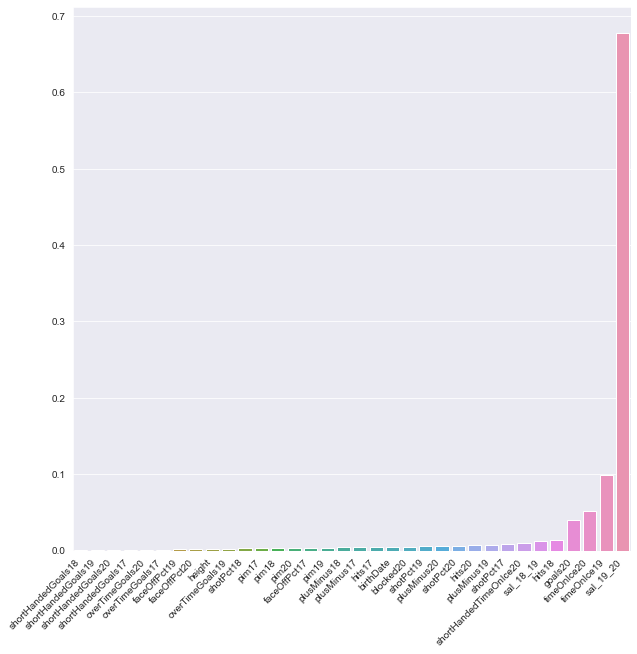

In [127]:
y = [val for val in feature_importances.values()]
x = [key for key in feature_importances.keys()]

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x,y)
plt.xticks(rotation=45, ha='right');

#### Now that we have our feature importances, lets visually compare our models predicted values vs the true values.

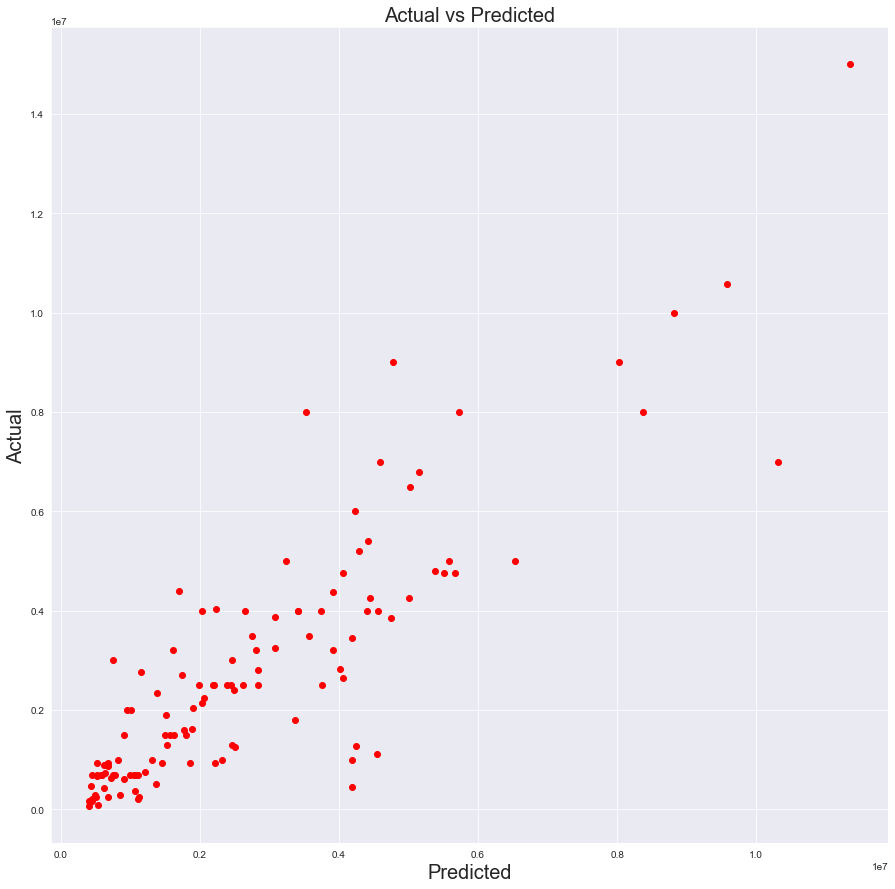

In [128]:
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(test_yhat, y_test_num , color='red', label='Predicted')
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.savefig('images/final_model');

In [129]:
analysis = pd.DataFrame(test_yhat - y_test_num)
analysis['actual'] = y_test_num
analysis['predicted'] = test_yhat
analysis_low = analysis[(analysis['sal_20_21'] <= 1200000) & (analysis['sal_20_21'] >= -1200000)]
analysis_pos = analysis[(analysis['sal_20_21'] >= 1200000)]
analysis_neg = analysis[(analysis['sal_20_21'] <= -1200000)]

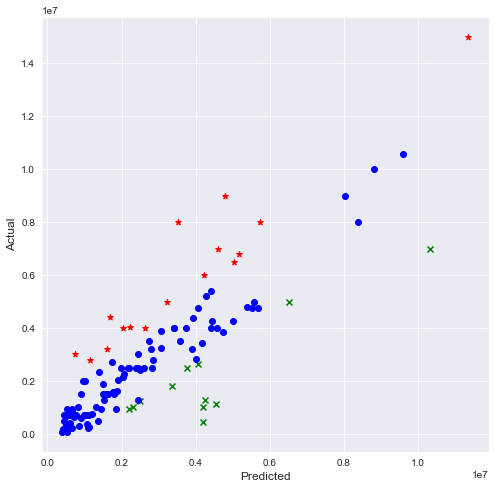

In [130]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(analysis_pos['predicted'], analysis_pos['actual'], marker='x', color = 'green', label='> $1.2M')
ax.scatter(analysis_neg['predicted'], analysis_neg['actual'], marker='*', color = 'red', label='> -$1.2M')
ax.scatter(analysis_low['predicted'], analysis_low['actual'], marker='o', color='blue', label='< +/- $1.2M')
# plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
# plt.legend()
plt.savefig('images/final_model');

In [131]:
len(analysis_neg) + len(analysis_pos) / len(analysis)

16.098360655737704

In [132]:
final_analysis_pos = analysis[(analysis['sal_20_21'] >= 1200000)]
final_analysis_neg = analysis[(analysis['sal_20_21'] <= -1200000)]

final_analysis_pos = final_analysis_pos.reset_index()
final_analysis_neg = final_analysis_neg.reset_index()

In [133]:
df = df.reset_index()

In [134]:
df_describe = df.describe().reset_index().loc[1:1, :]

In [135]:
final_analysis_df_pos = df[df['index'].isin(final_analysis_pos['index'])]
final_analysis_df_pos = final_analysis_df_pos[x]
pos = final_analysis_df_pos.describe().reset_index().loc[1:1, :]
pos = pos.drop('index', axis=1)

In [136]:
pos.subtract(df_describe[x])

,shortHandedGoals18,shortHandedGoals19,shortHandedGoals20,shortHandedGoals17,overTimeGoals20,overTimeGoals17,faceOffPct19,faceOffPct20,height,overTimeGoals19,shotPct18,pim17,pim18,pim20,faceOffPct17,pim19,plusMinus18,plusMinus17,hits17,birthDate,blocked20,shotPct19,plusMinus20,shotPct20,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,0.31,0.46,0.20,0.17,0.09,0.37,3.12,2.65,-0.24,0.32,1.46,5.73,2.68,16.13,10.20,17.17,-5.00,2.71,0.72,-4.55,8.67,0.50,1.11,0.32,38.62,-3.92,0.22,37.42,2056588.55,22.07,4.85,256.38,353.24,787304.47


In [137]:
final_analysis_df_pos

,shortHandedGoals18,shortHandedGoals19,shortHandedGoals20,shortHandedGoals17,overTimeGoals20,overTimeGoals17,faceOffPct19,faceOffPct20,height,overTimeGoals19,shotPct18,pim17,pim18,pim20,faceOffPct17,pim19,plusMinus18,plusMinus17,hits17,birthDate,blocked20,shotPct19,plusMinus20,shotPct20,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
63,1.00,1.00,0.00,1.00,1.00,4.00,51.26,51.20,75,0.00,15.29,41.00,2.00,36.00,51.94,42.00,4.00,2.00,86.00,1985,23.00,7.47,-21.00,9.30,66.00,-20.00,12.80,82.47,5000000.00,27.00,17.00,1016.05,1380.00,3000000.00
70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74,0.00,3.50,20.00,12.00,20.00,100.00,18.00,-27.00,-11.00,111.00,1993,79.00,5.30,7.00,2.10,92.00,-22.00,1.40,159.01,0.00,163.00,1.00,1150.18,1669.31,0.00
84,1.00,3.00,1.00,3.00,0.00,1.00,42.85,43.13,69,3.00,18.68,81.00,63.00,82.00,36.11,96.00,25.00,18.00,51.00,1988,19.00,15.58,25.00,15.10,55.00,15.00,17.26,111.06,8000000.00,37.00,28.00,1361.39,1550.16,7500000.00
113,2.00,0.00,0.00,1.00,1.00,0.00,51.07,49.55,76,0.00,17.43,34.00,42.00,28.00,49.14,34.00,8.00,17.00,42.00,1984,22.00,10.23,-9.00,16.80,24.00,-7.00,13.27,18.00,0.00,42.00,19.00,1130.53,1468.09,3500000.00
132,nan,0.00,0.00,nan,1.00,nan,48.99,46.15,76,1.00,nan,nan,nan,106.00,nan,75.00,nan,nan,nan,1999,43.00,10.28,-14.00,8.10,303.00,-10.00,nan,3.22,925000.00,nan,21.00,1344.20,1137.46,925000.00
137,0.00,0.00,0.00,0.00,0.00,1.00,56.59,49.84,72,0.00,10.95,55.00,50.00,62.00,46.06,44.00,1.00,-4.00,157.00,1987,50.00,12.06,-3.00,7.60,212.00,12.00,14.05,100.16,5500000.00,182.00,10.00,1250.44,1292.23,5500000.00
155,0.00,0.00,2.00,0.00,0.00,0.00,35.00,34.61,73,0.00,16.25,16.00,26.00,20.00,38.63,26.00,-10.00,6.00,99.00,1991,53.00,10.00,16.00,14.30,125.00,-3.00,10.71,162.35,0.00,130.00,12.00,1145.53,1037.33,0.00
193,3.00,3.00,3.00,0.00,0.00,0.00,41.60,31.54,71,0.00,8.90,27.00,50.00,56.00,42.47,71.00,7.00,-7.00,51.00,1991,46.00,10.33,0.00,10.50,191.00,-19.00,3.45,175.58,1800000.00,216.00,21.00,1103.23,1326.57,474173.00
222,0.00,0.00,0.00,0.00,1.00,1.00,20.00,25.00,70,3.00,9.47,32.00,32.00,40.00,13.72,22.00,-20.00,11.00,28.00,1988,19.00,12.90,8.00,12.00,24.00,2.00,11.64,2.15,12000000.00,18.00,33.00,1493.51,1821.37,9800000.00
298,0.00,3.00,0.00,0.00,0.00,0.00,49.34,45.28,75,0.00,10.67,22.00,26.00,18.00,51.99,26.00,0.00,-26.00,34.00,1985,41.00,12.23,6.00,12.60,77.00,-5.00,4.69,64.40,0.00,71.00,17.00,1112.45,1430.49,0.00


In [138]:
final_analysis_df_neg = df[df['index'].isin(final_analysis_neg['index'])]
final_analysis_df_neg = final_analysis_df_neg[x]
neg = final_analysis_df_neg.describe().reset_index().loc[1:1, :]
neg = neg.drop('index', axis=1)

In [139]:
neg.subtract(df_describe[x])

,shortHandedGoals18,shortHandedGoals19,shortHandedGoals20,shortHandedGoals17,overTimeGoals20,overTimeGoals17,faceOffPct19,faceOffPct20,height,overTimeGoals19,shotPct18,pim17,pim18,pim20,faceOffPct17,pim19,plusMinus18,plusMinus17,hits17,birthDate,blocked20,shotPct19,plusMinus20,shotPct20,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,-0.14,-0.06,0.08,-0.21,0.07,-0.07,10.97,-12.85,0.42,-0.35,0.38,4.65,-1.27,1.97,-4.13,-1.31,-0.14,4.56,3.54,0.72,14.27,-0.14,1.65,0.17,1.62,4.83,0.06,-3.98,-365286.45,2.29,2.06,233.52,257.06,785231.30


In [140]:
final_analysis_df_neg

,shortHandedGoals18,shortHandedGoals19,shortHandedGoals20,shortHandedGoals17,overTimeGoals20,overTimeGoals17,faceOffPct19,faceOffPct20,height,overTimeGoals19,shotPct18,pim17,pim18,pim20,faceOffPct17,pim19,plusMinus18,plusMinus17,hits17,birthDate,blocked20,shotPct19,plusMinus20,shotPct20,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
22,1.00,2.00,3.00,0.00,0.00,0.00,49.06,53.48,71,0.00,9.46,30.00,23.00,41.00,49.64,36.00,-12.00,9.00,144.00,1991,39.00,18.02,12.00,14.90,133.00,22.00,9.76,112.00,3500000.00,128.00,10.00,686.06,1023.44,3750000.00
75,0.00,0.00,0.00,nan,0.00,nan,100.00,0.00,75,0.00,6.25,nan,6.00,35.00,nan,66.00,5.00,nan,nan,1996,84.00,2.30,9.00,2.50,106.00,17.00,nan,87.53,0.00,18.00,2.00,1338.32,1401.17,0.00
86,1.00,1.00,2.00,0.00,0.00,0.00,45.86,46.63,75,0.00,9.40,36.00,18.00,21.00,45.96,20.00,8.00,13.00,101.00,1992,34.00,7.74,9.00,11.00,83.00,-1.00,11.32,63.06,0.00,76.00,16.00,1175.14,1358.56,0.00
148,0.00,1.00,0.00,0.00,1.00,0.00,63.63,26.92,72,0.00,11.34,38.00,26.00,16.00,37.83,22.00,-1.00,0.00,41.00,1997,37.00,11.16,6.00,10.40,24.00,22.00,10.80,129.44,0.00,31.00,16.00,1271.41,1625.26,16000000.00
211,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,74,0.00,3.67,34.00,14.00,6.00,0.00,4.00,22.00,27.00,67.00,1990,50.00,4.26,-13.00,3.50,36.00,0.00,7.79,7.23,0.00,36.00,3.00,913.54,594.32,0.00
227,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,78,0.00,7.45,73.00,103.00,65.00,0.00,75.00,4.00,-20.00,153.00,1995,66.00,7.00,6.00,6.20,175.00,19.00,0.00,108.41,0.00,278.00,4.00,1136.58,1204.16,0.00
244,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,0.00,6.54,12.00,20.00,14.00,0.00,18.00,-42.00,-3.00,77.00,1991,72.00,3.45,-1.00,4.20,62.00,0.00,8.03,49.33,5500000.00,95.00,3.00,1266.44,1767.06,6000000.00
297,0.00,0.00,0.00,0.00,2.00,0.00,46.15,0.00,74,0.00,12.77,105.00,61.00,74.00,34.78,62.00,-1.00,14.00,65.00,1997,22.00,16.43,-5.00,12.20,122.00,14.00,9.15,0.15,0.00,80.00,23.00,1263.15,1407.55,5000000.00
304,0.00,0.00,0.00,0.00,1.00,0.00,35.00,35.71,75,0.00,14.29,14.00,27.00,22.00,28.57,14.00,3.00,13.00,31.00,1995,34.00,12.00,11.00,19.40,26.00,2.00,10.81,0.12,0.00,40.00,20.00,881.38,845.32,0.00
310,0.00,0.00,0.00,nan,0.00,nan,100.00,0.00,70,0.00,4.76,nan,8.00,17.00,nan,6.00,-11.00,nan,nan,1998,92.00,3.45,1.00,4.20,46.00,8.00,nan,6.38,0.00,46.00,4.00,1491.55,1631.11,0.00


In [141]:
# PIM20, hits20, 

## Conclusion

#### This model building process has been successful and does a good job at predicting players salaries. This process will give the NHLPA and advantage when negotiating contract prices with the ability to get expected salaries in a short amount of time through our user interface.